In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#import seaborn as sns
#import matplotlib as mlp
import matplotlib.pyplot as plt
#from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


# import dataset
dfPhiladelphia = pd.read_csv("data/tmp/dfPhiladelphia.csv.zip")
dfPhiladelphia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589215 entries, 0 to 589214
Data columns (total 32 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   start_date                              589215 non-null  object 
 1   end_date                                589215 non-null  object 
 2   start_time_hourly                       589215 non-null  int64  
 3   end_time_hourly                         589215 non-null  int64  
 4   start_station_id                        589215 non-null  int64  
 5   end_station_id                          589215 non-null  int64  
 6   bike_id                                 589215 non-null  int64  
 7   start_latitude                          589215 non-null  float64
 8   start_longitude                         589215 non-null  float64
 9   end_latitude                            589215 non-null  float64
 10  end_longitude                           5892

# 4. Predictive Analytics

- Since the **total system-level demand in the next hour** is of our interest, the station-dependent demand is not needed in this task.
- Our target value is `y = numOfRentedBikes`

## 4.1 Feature Engineering

In this subtask, we will:
- Develop a rich set of features that we expect to be correlated with our target
- We will justify the selection of features

#### Creating the dataframe we need for our predicition.

In [2]:
# test for duplicates in start_date and start_time_hourly
len(dfPhiladelphia)-len(dfPhiladelphia.drop_duplicates(subset = ['start_date', 'start_time_hourly']))

580651

In [3]:
# drop the above checked duplicates, because we predict hourly
dfPhiladelphia.drop_duplicates(inplace=True, ignore_index = True,subset = ['start_date', 'start_time_hourly'])

In [4]:
# delete the last row of dfPhiladelphia, because its value is from 2020
dfPhiladelphia = dfPhiladelphia[:-1]

In [5]:
dfPhiladelphia['start_date'] = pd.to_datetime(dfPhiladelphia['start_date'])

In [6]:
dfPhiladelphia['start_day'] = dfPhiladelphia['start_date'].dt.day

In [7]:
dfPhiladelphia = dfPhiladelphia[['start_month', 'start_day', 'start_time_hourly', 'numOfRentedBikesHourly']]
dfPhiladelphia['year'] = 2019
dfPhiladelphia.rename(columns={"start_day": "day", "start_month": "month", "start_time_hourly": "hour"}, 
                      inplace = True)
dfPhiladelphia['date'] = pd.to_datetime(dfPhiladelphia[['year', 'month', 'day','hour']])
dfPhiladelphia

,month,day,hour,numOfRentedBikesHourly,year,date
0,1,1,0,2,2019,2019-01-01 00:00:00
1,1,1,1,8,2019,2019-01-01 01:00:00
2,1,1,2,10,2019,2019-01-01 02:00:00
3,1,1,3,7,2019,2019-01-01 03:00:00
4,1,1,4,3,2019,2019-01-01 04:00:00
...,...,...,...,...,...,...
8558,12,31,19,44,2019,2019-12-31 19:00:00
8559,12,31,20,33,2019,2019-12-31 20:00:00
8560,12,31,21,24,2019,2019-12-31 21:00:00
8561,12,31,22,26,2019,2019-12-31 22:00:00


In [8]:
# import dfWeather and edit it
dfWeather = pd.read_csv("data/tmp/dfWeather.csv")
dfWeather['date_time'] = pd.to_datetime(dfWeather['date_time'])
dfWeather = dfWeather[:-1]
dfWeather

,date_time,max_temp,min_temp,isPrecip
0,2019-01-01 00:00:00,6.950,6.4,True
1,2019-01-01 01:00:00,7.075,6.8,True
2,2019-01-01 02:00:00,7.200,7.2,True
3,2019-01-01 03:00:00,8.050,7.8,True
4,2019-01-01 04:00:00,9.400,8.3,True
...,...,...,...,...
8755,2019-12-31 19:00:00,7.375,7.1,False
8756,2019-12-31 20:00:00,7.800,7.8,False
8757,2019-12-31 21:00:00,8.300,8.3,False
8758,2019-12-31 22:00:00,8.300,8.3,False


In [9]:
# merge dfWeather and dfPhiladelphia
dfPhiladelphia = dfPhiladelphia[['date', 'numOfRentedBikesHourly']]
dfPhiladelphia = dfPhiladelphia.merge(dfWeather, left_on=["date"], 
                                      right_on=["date_time"], how="right")
dfPhiladelphia.drop(columns = ['date'], inplace = True)
dfPhiladelphia

,numOfRentedBikesHourly,date_time,max_temp,min_temp,isPrecip
0,2.0,2019-01-01 00:00:00,6.950,6.4,True
1,8.0,2019-01-01 01:00:00,7.075,6.8,True
2,10.0,2019-01-01 02:00:00,7.200,7.2,True
3,7.0,2019-01-01 03:00:00,8.050,7.8,True
4,3.0,2019-01-01 04:00:00,9.400,8.3,True
...,...,...,...,...,...
8755,44.0,2019-12-31 19:00:00,7.375,7.1,False
8756,33.0,2019-12-31 20:00:00,7.800,7.8,False
8757,24.0,2019-12-31 21:00:00,8.300,8.3,False
8758,26.0,2019-12-31 22:00:00,8.300,8.3,False


**FEATURE: `daOfWeek`**

In [10]:
# creating dayOfWeek
dfPhiladelphia['dayOfWeek'] = pd.to_datetime(dfPhiladelphia["date_time"]).dt.day_name()
dfPhiladelphia.head()

,numOfRentedBikesHourly,date_time,max_temp,min_temp,isPrecip,dayOfWeek
0,2.0,2019-01-01 00:00:00,6.950,6.4,True,Tuesday
1,8.0,2019-01-01 01:00:00,7.075,6.8,True,Tuesday
2,10.0,2019-01-01 02:00:00,7.200,7.2,True,Tuesday
3,7.0,2019-01-01 03:00:00,8.050,7.8,True,Tuesday
4,3.0,2019-01-01 04:00:00,9.400,8.3,True,Tuesday


**FEATURE: `isWeekend`**

In [11]:
def isWeekend(dayOfWeek):
    if(dayOfWeek in ["Saturday","Sunday"]):
        return True
    else:
        return False

In [12]:
dfPhiladelphia["isWeekend"] = dfPhiladelphia["dayOfWeek"].map(isWeekend)

**FEATURE: `isHoliday`**
- You need to install holidays

In [13]:
from datetime import date
import holidays

# Select country
us_holidays = holidays.US()
us_holidays

holidays.country_holidays('US')

In [14]:
dfPhiladelphia = dfPhiladelphia.assign(isHoliday=lambda x: x["date_time"].dt.date.apply(lambda h: h in us_holidays))

**FEATURE: `season`**

In [15]:
# Returns the day of the year
def day_match(ts):
    return pd.Period(ts, freq='D').day_of_year

#seasons = {'spring': (start='2019-03-20', end='2019-06-20'),
#           'summer': (start='2019/06/21', end='2019/09/22'),
#           'autumn': (start='2019/09/23', end='2019/12/21'),
#           'winter': rest}

# Create Array to map days to seasons (1 - 4)
seasons = ['winter' for i in range(0,78)]
seasons.extend('spring' for i in range(0,93))
seasons.extend('summer' for i in range(0,94))
seasons.extend('autumn' for i in range(0,90))
seasons.extend('winter' for i in range(0,10))

# Create dictionary for lambda expression
day_to_season = {}
for i in range(0,365):
    day_to_season[i+1] = seasons[i]
    
# Map start_date to day of the year (day_match) and afterwards map this to seasonnames (day_to_season)
dfPhiladelphia["season"] = dfPhiladelphia["date_time"].map(day_match).map(day_to_season)

In [16]:
print("In 2019 there were:\n", 
      "•", pd.Period("2019-03-19").day_of_year + (pd.Period("2019-12-31").day_of_year - pd.Period("2019/12/21").day_of_year), "winter days\n", 
      "•", pd.Period("2019/06/20").day_of_year - pd.Period("2019-03-19").day_of_year, "spring days\n",
      "•", pd.Period("2019/09/22").day_of_year - pd.Period("2019/06/20").day_of_year, "summer days\n",
      "•", pd.Period("2019/12/21").day_of_year - pd.Period("2019/09/22").day_of_year, "autumn days\n")

In 2019 there were:
 • 88 winter days
 • 93 spring days
 • 94 summer days
 • 90 autumn days



**FEATURE: `isRushhour`**
- Wikipedia: Rush hour may be 5–9 AM (5:00–9:00) and 4–8 PM (sometimes from 4-9 PM) (16:00–20:00 (sometimes from 16:00-21:00))
- TomTom: https://www.tomtom.com/traffic-index/philadelphia-traffic/#:~:text=2020-,2019,-Best%20time%20to
- We took the TomTom statistics for deciding, when rushhour is starting and ending, since it is tailored for Philadelphia 2019 traffic

In [17]:
# Create feature isRushour
def isRushhour(time):
    if (time in [7,8,9,16,17,18,19]):
        return True
    else: 
        return False

dfPhiladelphia['isRushhour'] = dfPhiladelphia['date_time'].dt.hour.apply(lambda x:isRushhour(x))
dfPhiladelphia.head()

,numOfRentedBikesHourly,date_time,max_temp,min_temp,isPrecip,dayOfWeek,isWeekend,isHoliday,season,isRushhour
0,2.0,2019-01-01 00:00:00,6.950,6.4,True,Tuesday,False,True,winter,False
1,8.0,2019-01-01 01:00:00,7.075,6.8,True,Tuesday,False,True,winter,False
2,10.0,2019-01-01 02:00:00,7.200,7.2,True,Tuesday,False,True,winter,False
3,7.0,2019-01-01 03:00:00,8.050,7.8,True,Tuesday,False,True,winter,False
4,3.0,2019-01-01 04:00:00,9.400,8.3,True,Tuesday,False,True,winter,False


In [18]:
dfPhiladelphia

,numOfRentedBikesHourly,date_time,max_temp,min_temp,isPrecip,dayOfWeek,isWeekend,isHoliday,season,isRushhour
0,2.0,2019-01-01 00:00:00,6.950,6.4,True,Tuesday,False,True,winter,False
1,8.0,2019-01-01 01:00:00,7.075,6.8,True,Tuesday,False,True,winter,False
2,10.0,2019-01-01 02:00:00,7.200,7.2,True,Tuesday,False,True,winter,False
3,7.0,2019-01-01 03:00:00,8.050,7.8,True,Tuesday,False,True,winter,False
4,3.0,2019-01-01 04:00:00,9.400,8.3,True,Tuesday,False,True,winter,False
...,...,...,...,...,...,...,...,...,...,...
8755,44.0,2019-12-31 19:00:00,7.375,7.1,False,Tuesday,False,False,winter,True
8756,33.0,2019-12-31 20:00:00,7.800,7.8,False,Tuesday,False,False,winter,False
8757,24.0,2019-12-31 21:00:00,8.300,8.3,False,Tuesday,False,False,winter,False
8758,26.0,2019-12-31 22:00:00,8.300,8.3,False,Tuesday,False,False,winter,False


**FEATURE: `start_month`, `start_day` and `start_time_hourly`**

In [19]:
#splitting date_time into month, day and hour
dfPhiladelphia['start_day'] = dfPhiladelphia['date_time'].dt.day
dfPhiladelphia['start_month'] = dfPhiladelphia['date_time'].dt.month
dfPhiladelphia['start_time_hourly'] = dfPhiladelphia['date_time'].dt.hour
dfPhiladelphia.drop(columns = ['date_time'], inplace = True)
dfPhiladelphia

,numOfRentedBikesHourly,max_temp,min_temp,isPrecip,dayOfWeek,isWeekend,isHoliday,season,isRushhour,start_day,start_month,start_time_hourly
0,2.0,6.950,6.4,True,Tuesday,False,True,winter,False,1,1,0
1,8.0,7.075,6.8,True,Tuesday,False,True,winter,False,1,1,1
2,10.0,7.200,7.2,True,Tuesday,False,True,winter,False,1,1,2
3,7.0,8.050,7.8,True,Tuesday,False,True,winter,False,1,1,3
4,3.0,9.400,8.3,True,Tuesday,False,True,winter,False,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,44.0,7.375,7.1,False,Tuesday,False,False,winter,True,31,12,19
8756,33.0,7.800,7.8,False,Tuesday,False,False,winter,False,31,12,20
8757,24.0,8.300,8.3,False,Tuesday,False,False,winter,False,31,12,21
8758,26.0,8.300,8.3,False,Tuesday,False,False,winter,False,31,12,22


#### Replace null values

In [20]:
# replace null values by zero (in numOfRentedBikesHourly)
dfPhiladelphia.fillna(0, inplace = True)

The feature creation process was already done in task 1: This are all features which we created in Task 1

**Remove unnecessary features**

We won't need:
- 'end_date', because
- 'end_time_hourly', because
- 'start_station_id', because we are interested in the **total system-level demand in the next hour**
- 'end_station_id', because
- 'start_latitude', because
- 'start_longitude', because
- 'end_latitude', because
- 'end_longitude', because
- 'start_station_name', because
- 'end_station_name', because
- 'tripduration_sec', because

We will need:
- 'start_date', because
- 'start_time_hourly', because
- 'numOfRentedBikes', because

We will test/evaluate if we need the following features, in a later step (x.x.x):
- 'min_temp', because
- 'max_temp', because
- 'precip', because
- 'user_type', because
- 'dayOfWeek', because
- 'isWeekend', because
- 'season', because
- 'isHoliday', because
- 'isRushhour', because
- #'tripLengthDistance', because

In [21]:
#Take only necessary columns (implicit drop of unselected columns)
dfPhiladelphia = dfPhiladelphia[['start_month', 'start_day', 'start_time_hourly', 'dayOfWeek',
                                'isWeekend', 'isHoliday', 'season', 'isRushhour','max_temp', 
                                 'min_temp', 'isPrecip','numOfRentedBikesHourly']]

### 4.1.1 Dummy Feature Creation (maybe after evaluation)
- We already created all features we need in Task 1, but we need to change some features into dummy variables to assure predictive performance

In [22]:
# here just 2 blocks of code

### 4.1.2 Justify the selection of features 

In [23]:
# Variance criteria or correlation criteria or filtering or embedded methods
# we will take variance & correlations

#### Variance:

In [24]:
#### take out features which will become dummys
#### season and so on missing, but we do know the variance because, we defined it
dfPhiladelphia[['start_time_hourly', 'min_temp', 'max_temp', 'isPrecip', 'dayOfWeek', 'isWeekend', 'isHoliday', 'isRushhour', 'numOfRentedBikesHourly']].var()

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2653/1893051211.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfPhiladelphia[['start_time_hourly', 'min_temp', 'max_temp', 'isPrecip', 'dayOfWeek', 'isWeekend', 'isHoliday', 'isRushhour', 'numOfRentedBikesHourly']].var()


start_time_hourly           47.922137
min_temp                   103.864476
max_temp                   104.211228
isPrecip                     0.078957
isWeekend                    0.203769
isHoliday                    0.026650
isRushhour                   0.206621
numOfRentedBikesHourly    4310.690580
dtype: float64

In [25]:
# min_temp & max_temp same variance => validate if they have different values

#### Correlations

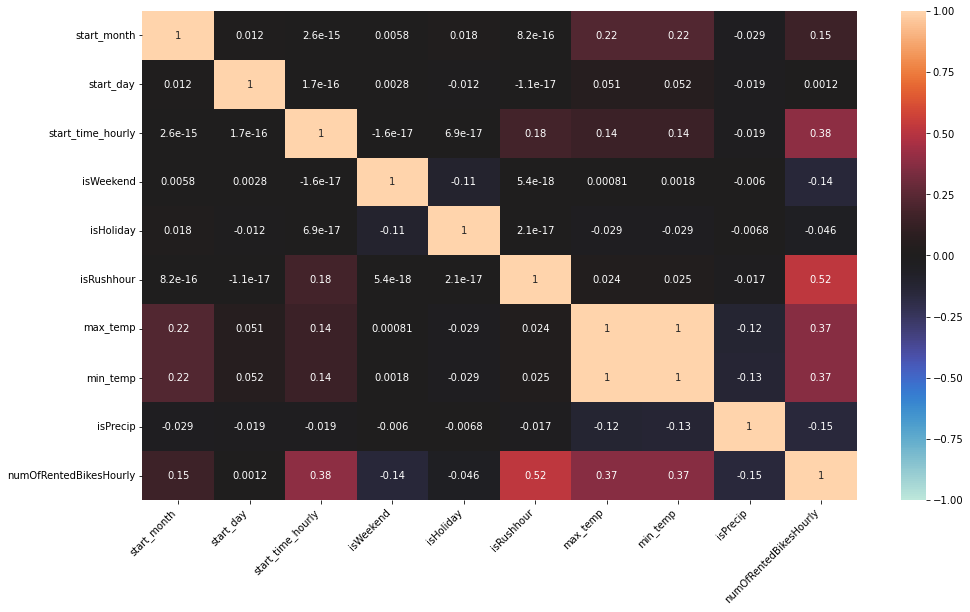

In [26]:
######## make named features like season to 0/1/2/3 so they show up here, before we make them a dummy variable like hours
import seaborn as sns
corr = dfPhiladelphia.corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

#### ISSUMMER ETC ADDEN, user_type, (start_month)

#### Feature selection:
 
We will drop `max_temp` or `min_temp`, because they are perfectly correlated.

In [27]:
dfPhiladelphia.drop(columns = ['min_temp'], inplace = True)

### 4.1.3 (Visualisation of dependencies)

## 4.2 Model Building & Evaluation

In [28]:
# function for normalize numeric and encode categorical features and for create pipeline

def pipeline_for_prediction(categoric, numeric, model):
    
    numeric_transformer = Pipeline(steps=[("standard_scaler", StandardScaler())])
    categorical_transformer = Pipeline(
        steps=[("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical scaler", numeric_transformer, numeric),
            ("one hot encoder", categorical_transformer, categoric),
        ]
    )
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", model)]
    )
    return pipeline

In [29]:
# defining categorical and numeric features of dfPhiladelphia

categoric = ['isPrecip', 'start_time_hourly','dayOfWeek','isWeekend','start_month','start_day','season',
             'isHoliday','isRushhour']
numeric = ['max_temp']


In [30]:
# function for getting different scores for a model

def get_prediction_scores(y_true, y_predicted):
    print("MODEL SCORES:")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_predicted): .3f}")
    print(f"MSE: {metrics.mean_squared_error(y_true, y_predicted): .3f}")
    print(f"RMSE: {math.sqrt(metrics.mean_squared_error(y_true, y_predicted)): .3f}")
    print(f"R2: {100 * metrics.r2_score(y_true, y_predicted): .3f} %")
    print(f"Max Residual Error: {metrics.max_error(y_true, y_predicted): .3f}")

In [31]:
# function for creating pipeline and fitting model (created by the pipeline), predict and printing scores

def pipeline_fit_predict(reg, categoric, numeric, x_train, y_train, x_val, y_val):
    pipeline = pipeline_for_prediction(categoric, numeric, reg)
    pipeline.fit(x_train, y_train)
    y_predict = pipeline.predict(x_val)
    get_prediction_scores(y_val, y_predict)

**Split the dataset in trainset, validationset and testset (50-20-30)**

In [32]:
from sklearn.model_selection import train_test_split

#split the data set in 70% training set and 30% testing set
#x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3,random_state=42)
x_train, x_test, y_train, y_test = train_test_split(dfPhiladelphia.drop('numOfRentedBikesHourly', axis=1)
                                                    , dfPhiladelphia['numOfRentedBikesHourly'], 
                                                    test_size=0.3,random_state=42)

# save the combination of training and validation set in extra variables
x_train_val = x_train
y_train_val = y_train

#split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train, y_train &rarr; 50% input features for training the model
- x_val, y_val &rarr; 20% to select hyperparameters
- x_test, y_test &rarr; 30% to control the accurancy of the model

### 4.2.1 First Regression: Linear Regression (as Benchmark)

Using Linear Regression to predict the `numOfRentedBikesHourly`.

In [33]:
# creating the regression model

lin_reg = LinearRegression()

In [34]:
pipeline = pipeline_fit_predict(lin_reg, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  26.700
MSE:  1313.835
RMSE:  36.247
R2:  69.936 %
Max Residual Error:  163.838


### 4.2.2 Second Regression: Decision Tree

Using Decision Tree Regression to predict the `numOfRentedBikesHourly`.

In [35]:
# creating the regression model

tree_reg = DecisionTreeRegressor(criterion="friedman_mse", random_state=42) 

In [36]:
pipeline = pipeline_fit_predict(tree_reg, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  17.129
MSE:  818.330
RMSE:  28.606
R2:  81.274 %
Max Residual Error:  240.000


**Looking for the best Hyperparameters**

In [37]:
# function for finding the best hyperparameter by using RandomizedSearchCV and RepeatedStratifiedKFold
"""parameter:
   - pipeline: used pipeline for grid search (the pipeline contains the model)
   - x_val: data set (features) used for grid search
   - y_val: data set (target value) used for grid search
   - model_par: parameters for which the grid search is done
   - score: used score measure 
   - n_iter: how often grid search will be done
   - n_repeats: how often the data set is randomly splitted (by using the same random hyperparameter) in n_splits
   - n_splits: number of splits in RepeatedStratifiedKFold
   - verbose: getting information during the grid search
"""


from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

def find_best_hyperparameters(pipeline, x_val, y_val, model_par, score, n_iter = 50,  
                                   n_repeats=3, n_splits=5, n_jobs=1, verbose=True):
    
    print(f"Running grid search for the model based on {score}")
    grid_pipeline = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=model_par,
        n_jobs=n_jobs,
        n_iter=n_iter,
        cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42),
        scoring=score,
        random_state=42,
        verbose=verbose,
    )
    grid_pipeline.fit(x_val, y_val)
    print(f"Best {score} Score was: {grid_pipeline.best_score_}")
    print("The best hyper parameters for the model are:")
    print(grid_pipeline.best_params_)

In [90]:
# creating the ranges for model parameter to use in find_best_hyperparameters

from scipy.stats import loguniform

model_para = {'model__max_depth': range(1,51),
              'model__ccp_alpha': loguniform(1e-4, 40e-1)
             }

In [91]:
pipeline = pipeline_for_prediction(categoric, numeric, tree_reg)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['max_temp']),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['isPrecip',
                                                   'start_time_hourly',
                                                   'dayOfWeek', 'isWeekend',
                                                   'start_month', 'start_day',
                                                   'season', 'isHoliday',
                                                   'isRushhour'])])),
                ('model',
                 DecisionTreeRegressor(criterion='friedman_mse',
                                       random_state=42))])

In [92]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 1/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-853.059 total time=   0.1s
[CV 2/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 2/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-813.248 total time=   0.1s
[CV 3/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 3/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-721.503 total time=   0.1s
[CV 4/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 4/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-684.743 total time=   0.1s
[CV 5/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 5/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-967.542 total time=   0.1s
[CV 6/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 6/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-858.124 total time=   0.1s
[CV 7/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 7/15; 1/50] END 

[CV 15/15; 3/50] END model__ccp_alpha=0.056893448500305, model__max_depth=39;, score=-973.606 total time=   0.1s
[CV 1/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 1/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-746.107 total time=   0.1s
[CV 2/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 2/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-862.207 total time=   0.1s
[CV 3/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 3/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-701.103 total time=   0.1s
[CV 4/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 4/15; 4/50] END model__ccp_alpha=0.011265463757625072, model__max_depth=23;, score=-678.102 total time=   0.1s
[CV 5/15; 4/50] START model__ccp_alpha=0.011265463757625072, model__max_depth=23
[CV 5/15; 4/50] END mo

[CV 13/15; 6/50] END model__ccp_alpha=0.0034335790313459948, model__max_depth=40;, score=-799.554 total time=   0.1s
[CV 14/15; 6/50] START model__ccp_alpha=0.0034335790313459948, model__max_depth=40
[CV 14/15; 6/50] END model__ccp_alpha=0.0034335790313459948, model__max_depth=40;, score=-821.049 total time=   0.1s
[CV 15/15; 6/50] START model__ccp_alpha=0.0034335790313459948, model__max_depth=40
[CV 15/15; 6/50] END model__ccp_alpha=0.0034335790313459948, model__max_depth=40;, score=-1004.609 total time=   0.1s
[CV 1/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22.
[CV 1/15; 7/50] END model__ccp_alpha=0.18138128787747848, model__max_depth=22;, score=-806.860 total time=   0.1s
[CV 2/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22.
[CV 2/15; 7/50] END model__ccp_alpha=0.18138128787747848, model__max_depth=22;, score=-792.243 total time=   0.1s
[CV 3/15; 7/50] START model__ccp_alpha=0.18138128787747848, model__max_depth=22.
[CV 3/15; 7

[CV 11/15; 9/50] END model__ccp_alpha=0.6775650126777126, model__max_depth=38;, score=-876.371 total time=   0.1s
[CV 12/15; 9/50] START model__ccp_alpha=0.6775650126777126, model__max_depth=38.
[CV 12/15; 9/50] END model__ccp_alpha=0.6775650126777126, model__max_depth=38;, score=-727.365 total time=   0.1s
[CV 13/15; 9/50] START model__ccp_alpha=0.6775650126777126, model__max_depth=38.
[CV 13/15; 9/50] END model__ccp_alpha=0.6775650126777126, model__max_depth=38;, score=-670.509 total time=   0.1s
[CV 14/15; 9/50] START model__ccp_alpha=0.6775650126777126, model__max_depth=38.
[CV 14/15; 9/50] END model__ccp_alpha=0.6775650126777126, model__max_depth=38;, score=-739.040 total time=   0.1s
[CV 15/15; 9/50] START model__ccp_alpha=0.6775650126777126, model__max_depth=38.
[CV 15/15; 9/50] END model__ccp_alpha=0.6775650126777126, model__max_depth=38;, score=-874.473 total time=   0.1s
[CV 1/15; 10/50] START model__ccp_alpha=0.00010082864412217383, model__max_depth=21
[CV 1/15; 10/50] END m

[CV 9/15; 12/50] END model__ccp_alpha=0.00010777537944204211, model__max_depth=25;, score=-791.353 total time=   0.1s
[CV 10/15; 12/50] START model__ccp_alpha=0.00010777537944204211, model__max_depth=25
[CV 10/15; 12/50] END model__ccp_alpha=0.00010777537944204211, model__max_depth=25;, score=-787.147 total time=   0.1s
[CV 11/15; 12/50] START model__ccp_alpha=0.00010777537944204211, model__max_depth=25
[CV 11/15; 12/50] END model__ccp_alpha=0.00010777537944204211, model__max_depth=25;, score=-940.596 total time=   0.1s
[CV 12/15; 12/50] START model__ccp_alpha=0.00010777537944204211, model__max_depth=25
[CV 12/15; 12/50] END model__ccp_alpha=0.00010777537944204211, model__max_depth=25;, score=-803.079 total time=   0.1s
[CV 13/15; 12/50] START model__ccp_alpha=0.00010777537944204211, model__max_depth=25
[CV 13/15; 12/50] END model__ccp_alpha=0.00010777537944204211, model__max_depth=25;, score=-821.823 total time=   0.1s
[CV 14/15; 12/50] START model__ccp_alpha=0.00010777537944204211, m

[CV 6/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-892.267 total time=   0.1s
[CV 7/15; 15/50] START model__ccp_alpha=0.0011782234791367942, model__max_depth=47
[CV 7/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-850.859 total time=   0.1s
[CV 8/15; 15/50] START model__ccp_alpha=0.0011782234791367942, model__max_depth=47
[CV 8/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-823.598 total time=   0.1s
[CV 9/15; 15/50] START model__ccp_alpha=0.0011782234791367942, model__max_depth=47
[CV 9/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-784.735 total time=   0.1s
[CV 10/15; 15/50] START model__ccp_alpha=0.0011782234791367942, model__max_depth=47
[CV 10/15; 15/50] END model__ccp_alpha=0.0011782234791367942, model__max_depth=47;, score=-750.867 total time=   0.1s
[CV 11/15; 15/50] START model__ccp_alpha=0.0011782234791367942, model__max_depth=

[CV 5/15; 18/50] END model__ccp_alpha=0.906770412312764, model__max_depth=7;, score=-1178.269 total time=   0.0s
[CV 6/15; 18/50] START model__ccp_alpha=0.906770412312764, model__max_depth=7...
[CV 6/15; 18/50] END model__ccp_alpha=0.906770412312764, model__max_depth=7;, score=-1092.311 total time=   0.0s
[CV 7/15; 18/50] START model__ccp_alpha=0.906770412312764, model__max_depth=7...
[CV 7/15; 18/50] END model__ccp_alpha=0.906770412312764, model__max_depth=7;, score=-1184.614 total time=   0.0s
[CV 8/15; 18/50] START model__ccp_alpha=0.906770412312764, model__max_depth=7...
[CV 8/15; 18/50] END model__ccp_alpha=0.906770412312764, model__max_depth=7;, score=-1331.083 total time=   0.0s
[CV 9/15; 18/50] START model__ccp_alpha=0.906770412312764, model__max_depth=7...
[CV 9/15; 18/50] END model__ccp_alpha=0.906770412312764, model__max_depth=7;, score=-1238.516 total time=   0.0s
[CV 10/15; 18/50] START model__ccp_alpha=0.906770412312764, model__max_depth=7..
[CV 10/15; 18/50] END model__c

[CV 2/15; 21/50] END model__ccp_alpha=2.7790511850146156, model__max_depth=50;, score=-771.520 total time=   0.1s
[CV 3/15; 21/50] START model__ccp_alpha=2.7790511850146156, model__max_depth=50.
[CV 3/15; 21/50] END model__ccp_alpha=2.7790511850146156, model__max_depth=50;, score=-609.425 total time=   0.1s
[CV 4/15; 21/50] START model__ccp_alpha=2.7790511850146156, model__max_depth=50.
[CV 4/15; 21/50] END model__ccp_alpha=2.7790511850146156, model__max_depth=50;, score=-601.287 total time=   0.1s
[CV 5/15; 21/50] START model__ccp_alpha=2.7790511850146156, model__max_depth=50.
[CV 5/15; 21/50] END model__ccp_alpha=2.7790511850146156, model__max_depth=50;, score=-901.833 total time=   0.1s
[CV 6/15; 21/50] START model__ccp_alpha=2.7790511850146156, model__max_depth=50.
[CV 6/15; 21/50] END model__ccp_alpha=2.7790511850146156, model__max_depth=50;, score=-710.603 total time=   0.1s
[CV 7/15; 21/50] START model__ccp_alpha=2.7790511850146156, model__max_depth=50.
[CV 7/15; 21/50] END mode

[CV 15/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-977.584 total time=   0.1s
[CV 1/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 1/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1280.393 total time=   0.0s
[CV 2/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 2/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1231.514 total time=   0.0s
[CV 3/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 3/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1243.781 total time=   0.0s
[CV 4/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV 4/15; 24/50] END model__ccp_alpha=0.0012859191209139947, model__max_depth=7;, score=-1080.781 total time=   0.0s
[CV 5/15; 24/50] START model__ccp_alpha=0.0012859191209139947, model__max_depth=7
[CV

[CV 12/15; 26/50] END model__ccp_alpha=0.000143965369814854, model__max_depth=14;, score=-721.759 total time=   0.1s
[CV 13/15; 26/50] START model__ccp_alpha=0.000143965369814854, model__max_depth=14
[CV 13/15; 26/50] END model__ccp_alpha=0.000143965369814854, model__max_depth=14;, score=-709.496 total time=   0.1s
[CV 14/15; 26/50] START model__ccp_alpha=0.000143965369814854, model__max_depth=14
[CV 14/15; 26/50] END model__ccp_alpha=0.000143965369814854, model__max_depth=14;, score=-766.607 total time=   0.1s
[CV 15/15; 26/50] START model__ccp_alpha=0.000143965369814854, model__max_depth=14
[CV 15/15; 26/50] END model__ccp_alpha=0.000143965369814854, model__max_depth=14;, score=-936.158 total time=   0.1s
[CV 1/15; 27/50] START model__ccp_alpha=0.00630498962541683, model__max_depth=50
[CV 1/15; 27/50] END model__ccp_alpha=0.00630498962541683, model__max_depth=50;, score=-852.662 total time=   0.1s
[CV 2/15; 27/50] START model__ccp_alpha=0.00630498962541683, model__max_depth=50
[CV 2/

[CV 10/15; 29/50] END model__ccp_alpha=0.009048838560499841, model__max_depth=42;, score=-751.106 total time=   0.1s
[CV 11/15; 29/50] START model__ccp_alpha=0.009048838560499841, model__max_depth=42
[CV 11/15; 29/50] END model__ccp_alpha=0.009048838560499841, model__max_depth=42;, score=-960.655 total time=   0.1s
[CV 12/15; 29/50] START model__ccp_alpha=0.009048838560499841, model__max_depth=42
[CV 12/15; 29/50] END model__ccp_alpha=0.009048838560499841, model__max_depth=42;, score=-762.241 total time=   0.1s
[CV 13/15; 29/50] START model__ccp_alpha=0.009048838560499841, model__max_depth=42
[CV 13/15; 29/50] END model__ccp_alpha=0.009048838560499841, model__max_depth=42;, score=-795.118 total time=   0.1s
[CV 14/15; 29/50] START model__ccp_alpha=0.009048838560499841, model__max_depth=42
[CV 14/15; 29/50] END model__ccp_alpha=0.009048838560499841, model__max_depth=42;, score=-816.678 total time=   0.1s
[CV 15/15; 29/50] START model__ccp_alpha=0.009048838560499841, model__max_depth=42


[CV 7/15; 32/50] END model__ccp_alpha=0.011743444594199003, model__max_depth=10;, score=-850.291 total time=   0.0s
[CV 8/15; 32/50] START model__ccp_alpha=0.011743444594199003, model__max_depth=10
[CV 8/15; 32/50] END model__ccp_alpha=0.011743444594199003, model__max_depth=10;, score=-901.843 total time=   0.0s
[CV 9/15; 32/50] START model__ccp_alpha=0.011743444594199003, model__max_depth=10
[CV 9/15; 32/50] END model__ccp_alpha=0.011743444594199003, model__max_depth=10;, score=-891.676 total time=   0.0s
[CV 10/15; 32/50] START model__ccp_alpha=0.011743444594199003, model__max_depth=10
[CV 10/15; 32/50] END model__ccp_alpha=0.011743444594199003, model__max_depth=10;, score=-777.678 total time=   0.0s
[CV 11/15; 32/50] START model__ccp_alpha=0.011743444594199003, model__max_depth=10
[CV 11/15; 32/50] END model__ccp_alpha=0.011743444594199003, model__max_depth=10;, score=-862.872 total time=   0.0s
[CV 12/15; 32/50] START model__ccp_alpha=0.011743444594199003, model__max_depth=10
[CV 1

[CV 6/15; 35/50] END model__ccp_alpha=0.00025541582590476536, model__max_depth=23;, score=-803.733 total time=   0.1s
[CV 7/15; 35/50] START model__ccp_alpha=0.00025541582590476536, model__max_depth=23
[CV 7/15; 35/50] END model__ccp_alpha=0.00025541582590476536, model__max_depth=23;, score=-858.983 total time=   0.1s
[CV 8/15; 35/50] START model__ccp_alpha=0.00025541582590476536, model__max_depth=23
[CV 8/15; 35/50] END model__ccp_alpha=0.00025541582590476536, model__max_depth=23;, score=-820.556 total time=   0.1s
[CV 9/15; 35/50] START model__ccp_alpha=0.00025541582590476536, model__max_depth=23
[CV 9/15; 35/50] END model__ccp_alpha=0.00025541582590476536, model__max_depth=23;, score=-773.687 total time=   0.1s
[CV 10/15; 35/50] START model__ccp_alpha=0.00025541582590476536, model__max_depth=23
[CV 10/15; 35/50] END model__ccp_alpha=0.00025541582590476536, model__max_depth=23;, score=-815.935 total time=   0.1s
[CV 11/15; 35/50] START model__ccp_alpha=0.00025541582590476536, model__

[CV 4/15; 38/50] END model__ccp_alpha=0.0017732277649908593, model__max_depth=24;, score=-633.649 total time=   0.1s
[CV 5/15; 38/50] START model__ccp_alpha=0.0017732277649908593, model__max_depth=24
[CV 5/15; 38/50] END model__ccp_alpha=0.0017732277649908593, model__max_depth=24;, score=-1050.396 total time=   0.1s
[CV 6/15; 38/50] START model__ccp_alpha=0.0017732277649908593, model__max_depth=24
[CV 6/15; 38/50] END model__ccp_alpha=0.0017732277649908593, model__max_depth=24;, score=-834.397 total time=   0.1s
[CV 7/15; 38/50] START model__ccp_alpha=0.0017732277649908593, model__max_depth=24
[CV 7/15; 38/50] END model__ccp_alpha=0.0017732277649908593, model__max_depth=24;, score=-866.310 total time=   0.1s
[CV 8/15; 38/50] START model__ccp_alpha=0.0017732277649908593, model__max_depth=24
[CV 8/15; 38/50] END model__ccp_alpha=0.0017732277649908593, model__max_depth=24;, score=-823.421 total time=   0.1s
[CV 9/15; 38/50] START model__ccp_alpha=0.0017732277649908593, model__max_depth=24

[CV 1/15; 41/50] END model__ccp_alpha=0.0005761935178124764, model__max_depth=25;, score=-869.248 total time=   0.1s
[CV 2/15; 41/50] START model__ccp_alpha=0.0005761935178124764, model__max_depth=25
[CV 2/15; 41/50] END model__ccp_alpha=0.0005761935178124764, model__max_depth=25;, score=-900.895 total time=   0.1s
[CV 3/15; 41/50] START model__ccp_alpha=0.0005761935178124764, model__max_depth=25
[CV 3/15; 41/50] END model__ccp_alpha=0.0005761935178124764, model__max_depth=25;, score=-724.342 total time=   0.1s
[CV 4/15; 41/50] START model__ccp_alpha=0.0005761935178124764, model__max_depth=25
[CV 4/15; 41/50] END model__ccp_alpha=0.0005761935178124764, model__max_depth=25;, score=-648.326 total time=   0.1s
[CV 5/15; 41/50] START model__ccp_alpha=0.0005761935178124764, model__max_depth=25
[CV 5/15; 41/50] END model__ccp_alpha=0.0005761935178124764, model__max_depth=25;, score=-1000.463 total time=   0.1s
[CV 6/15; 41/50] START model__ccp_alpha=0.0005761935178124764, model__max_depth=25

[CV 11/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-668.144 total time=   0.1s
[CV 12/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 12/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-783.471 total time=   0.1s
[CV 13/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 13/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-499.821 total time=   0.1s
[CV 14/15; 23/50] START model__ccp_alpha=0.00028150941749886896, model__max_depth=20
[CV 14/15; 23/50] END model__ccp_alpha=0.00028150941749886896, model__max_depth=20;, score=-872.126 total time=   0.1s
[CV 5/15; 25/50] START model__ccp_alpha=0.06415658128567595, model__max_depth=8.
[CV 5/15; 25/50] END model__ccp_alpha=0.06415658128567595, model__max_depth=8;, score=-919.233 total time=   0.1s
[CV 6/15; 25/50] START model__ccp_alpha=0.06415658128567595, model__max_de

[CV 14/15; 42/50] END model__ccp_alpha=3.481071045200102, model__max_depth=24;, score=-707.600 total time=   0.1s
[CV 15/15; 42/50] START model__ccp_alpha=3.481071045200102, model__max_depth=24.
[CV 15/15; 42/50] END model__ccp_alpha=3.481071045200102, model__max_depth=24;, score=-902.151 total time=   0.1s
[CV 1/15; 43/50] START model__ccp_alpha=0.006565509530788613, model__max_depth=8
[CV 1/15; 43/50] END model__ccp_alpha=0.006565509530788613, model__max_depth=8;, score=-1145.187 total time=   0.0s
[CV 2/15; 43/50] START model__ccp_alpha=0.006565509530788613, model__max_depth=8
[CV 2/15; 43/50] END model__ccp_alpha=0.006565509530788613, model__max_depth=8;, score=-1126.007 total time=   0.0s
[CV 3/15; 43/50] START model__ccp_alpha=0.006565509530788613, model__max_depth=8
[CV 3/15; 43/50] END model__ccp_alpha=0.006565509530788613, model__max_depth=8;, score=-1006.949 total time=   0.0s
[CV 4/15; 43/50] START model__ccp_alpha=0.006565509530788613, model__max_depth=8
[CV 4/15; 43/50] EN

[CV 1/15; 46/50] END model__ccp_alpha=0.2264303935720594, model__max_depth=33;, score=-837.308 total time=   0.1s
[CV 2/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33.
[CV 2/15; 46/50] END model__ccp_alpha=0.2264303935720594, model__max_depth=33;, score=-815.372 total time=   0.1s
[CV 3/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33.
[CV 3/15; 46/50] END model__ccp_alpha=0.2264303935720594, model__max_depth=33;, score=-633.961 total time=   0.1s
[CV 4/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33.
[CV 4/15; 46/50] END model__ccp_alpha=0.2264303935720594, model__max_depth=33;, score=-612.083 total time=   0.1s
[CV 5/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33.
[CV 5/15; 46/50] END model__ccp_alpha=0.2264303935720594, model__max_depth=33;, score=-915.309 total time=   0.1s
[CV 6/15; 46/50] START model__ccp_alpha=0.2264303935720594, model__max_depth=33.
[CV 6/15; 46/50] END mode

[CV 13/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-800.185 total time=   0.1s
[CV 14/15; 48/50] START model__ccp_alpha=0.004463553942105087, model__max_depth=41
[CV 14/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-819.937 total time=   0.1s
[CV 15/15; 48/50] START model__ccp_alpha=0.004463553942105087, model__max_depth=41
[CV 15/15; 48/50] END model__ccp_alpha=0.004463553942105087, model__max_depth=41;, score=-1012.551 total time=   0.1s
[CV 1/15; 49/50] START model__ccp_alpha=1.6244236976402378, model__max_depth=9..
[CV 1/15; 49/50] END model__ccp_alpha=1.6244236976402378, model__max_depth=9;, score=-1044.383 total time=   0.0s
[CV 2/15; 49/50] START model__ccp_alpha=1.6244236976402378, model__max_depth=9..
[CV 2/15; 49/50] END model__ccp_alpha=1.6244236976402378, model__max_depth=9;, score=-977.095 total time=   0.0s
[CV 3/15; 49/50] START model__ccp_alpha=1.6244236976402378, model__max_depth=9..
[CV 3/15; 49

**Training the model with the best hyperparameters**

In [56]:
tree_reg_last = DecisionTreeRegressor(criterion="friedman_mse", max_depth = 14, ccp_alpha =  1.3123484074006266)

In [93]:
pipeline_last = pipeline_fit_predict(tree_reg_last, categoric, numeric, x_val, y_val, x_test, y_test)

MODEL SCORES:
MAE:  16.669
MSE:  685.106
RMSE:  26.175
R2:  84.639 %
Max Residual Error:  241.300


In [55]:
# plot decision tree

from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
from sklearn import tree

def plot_regression_tree_sklearn(tree_depth):

    # Fit regression model (to full data)
    model = DecisionTreeRegressor(max_depth=tree_depth)
    model.fit(dfPhiladelphia['max_temp'].values.reshape((-1,1)), dfPhiladelphia['numOfRentedBikesHourly'].values) 
    
    dot_data = export_graphviz(model,
                              feature_names=["max_temp"])  
    
    graph = graphviz.Source(dot_data) 
    
    
    return graph

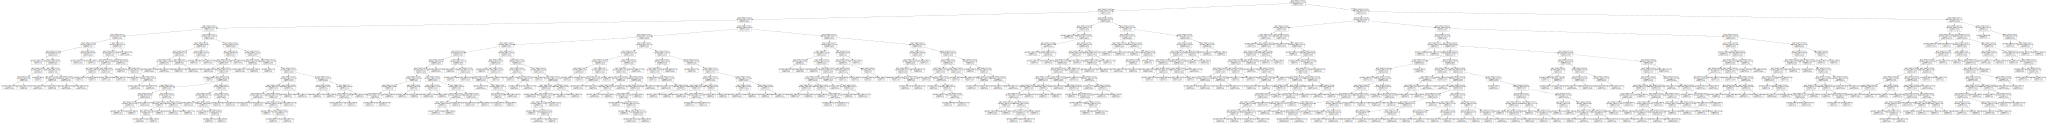

In [56]:
plot_regression_tree_sklearn(14)

### 4.2.2 Third Regression: Random Forest

Using Random Forest Regression to predict the `numOfRentedBikesHourly`.

In [79]:
# creating the regression model

forest_reg = RandomForestRegressor(n_estimators = 10,criterion="friedman_mse", random_state=42) 

In [80]:
pipeline = pipeline_fit_predict(forest_reg, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  14.675
MSE:  593.420
RMSE:  24.360
R2:  86.421 %
Max Residual Error:  220.000


**Looking for the best Hyperparameters**

In [81]:
# creating the ranges for model parameter to use in find_best_hyperparameters

from scipy.stats import loguniform
model_para = {'model__max_depth': range(1,51),
              'model__ccp_alpha': loguniform(1e-4, 40e-1)
             }

In [82]:
pipeline = pipeline_for_prediction(categoric, numeric, forest_reg)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['max_temp']),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['isPrecip',
                                                   'start_time_hourly',
                                                   'dayOfWeek', 'isWeekend',
                                                   'start_month', 'start_day',
                                                   'season', 'isHoliday',
                                                   'isRushhour'])])),
                ('model',
                 RandomForestRegressor(criterion='friedman_mse',
                                       n_estimators=10, random_state=42))])

In [85]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10, n_jobs=4)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 2/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 2/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-709.671 total time=   0.1s
[CV 6/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 6/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-741.785 total time=   0.1s
[CV 10/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 10/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-781.918 total time=   0.1s
[CV 14/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 14/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-919.389 total time=   0.1s
[CV 4/15; 2/50] START model__ccp_alpha=0.000698518491527025, model__max_depth=8.
[CV 4/15; 2/50] END model__ccp_alpha=0.000698518491527025, model__max_depth=8;, score=-983.559 total time=   0.1s
[CV 8/15; 2/50] S

[CV 4/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 4/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-861.820 total time=   0.1s
[CV 8/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 8/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-1082.870 total time=   0.1s
[CV 12/15; 1/50] START model__ccp_alpha=0.005292441863767901, model__max_depth=29
[CV 12/15; 1/50] END model__ccp_alpha=0.005292441863767901, model__max_depth=29;, score=-763.050 total time=   0.1s
[CV 1/15; 2/50] START model__ccp_alpha=0.000698518491527025, model__max_depth=8.
[CV 1/15; 2/50] END model__ccp_alpha=0.000698518491527025, model__max_depth=8;, score=-914.053 total time=   0.0s
[CV 2/15; 2/50] START model__ccp_alpha=0.000698518491527025, model__max_depth=8.
[CV 2/15; 2/50] END model__ccp_alpha=0.000698518491527025, model__max_depth=8;, score=-1111.285 total time=   0.1s
[CV 5/15; 2/50] ST

Best neg_mean_squared_error Score was: -750.3329964009224
The best hyper parameters for the model are:
{'model__ccp_alpha': 0.00010777537944204211, 'model__max_depth': 25}


**Training the model with the best hyperparameters**

In [86]:
forest_reg_end = DecisionTreeRegressor(criterion="friedman_mse", max_depth = 25, ccp_alpha = 0.00010777537944204211)

In [87]:
pipeline_end = pipeline_fit_predict(forest_reg_end, categoric, numeric, x_val, y_val, x_test, y_test)

MODEL SCORES:
MAE:  18.722
MSE:  968.815
RMSE:  31.126
R2:  78.278 %
Max Residual Error:  262.000


### Fourth Regression: Lasso Regression

Using Lasso Regression to predict the `numOfRentedBikesHourly`.

In [72]:
# creating the regression model

lasso_reg = Lasso()

In [73]:
pipeline = pipeline_fit_predict(lasso_reg, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  32.508
MSE:  1862.131
RMSE:  43.152
R2:  57.389 %
Max Residual Error:  200.645


**Looking for the best Hyperparameters**

In [74]:
# creating the ranges for model parameter to use in find_best_hyperparameters

from scipy.stats import loguniform
model_para = {'model__alpha': loguniform(1e-2, 1e2),
              'model__tol' : loguniform(1e-5,1e0)
             }

In [75]:
pipeline = pipeline_for_prediction(categoric, numeric, lasso_reg)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['max_temp']),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['isPrecip',
                                                   'start_time_hourly',
                                                   'dayOfWeek', 'isWeekend',
                                                   'start_month', 'start_day',
                                                   'season', 'isHoliday',
                                                   'isRushhour'])])),
                ('model', Lasso())])

In [76]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 1/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1219.175 total time=   0.0s
[CV 2/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 2/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1487.647 total time=   0.0s
[CV 3/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 3/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1201.771 total time=   0.0s
[CV 4/15; 1/50] START model__alpha=0.314891164795686, model__tol=0.5669849511478852
[CV 4/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1608.695 total time=   0.0s
[CV 5/15; 1/50] START model__alpha=0.314891164795686, model

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 15/15; 1/50] END model__alpha=0.314891164795686, model__tol=0.5669849511478852;, score=-1579.494 total time=   0.0s
[CV 1/15; 2/50] START model__alpha=8.471801418819974, model__tol=0.009846738873614563
[CV 1/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-2800.690 total time=   0.0s
[CV 2/15; 2/50] START model__alpha=8.471801418819974, model__tol=0.009846738873614563
[CV 2/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-3061.228 total time=   0.0s
[CV 3/15; 2/50] START model__alpha=8.471801418819974, model__tol=0.009846738873614563
[CV 3/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-2896.223 total time=   0.0s
[CV 4/15; 2/50] START model__alpha=8.471801418819974, model__tol=0.009846738873614563
[CV 4/15; 2/50] END model__alpha=8.471801418819974, model__tol=0.009846738873614563;, score=-3368.280 total time=   0.0s
[CV 5/15; 2/50] START model__alpha=8.471801418819974

[CV 4/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2848.423 total time=   0.0s
[CV 5/15; 5/50] START model__alpha=2.5378155082656626, model__tol=0.03470266988650412
[CV 5/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2629.767 total time=   0.0s
[CV 6/15; 5/50] START model__alpha=2.5378155082656626, model__tol=0.03470266988650412
[CV 6/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2456.639 total time=   0.0s
[CV 7/15; 5/50] START model__alpha=2.5378155082656626, model__tol=0.03470266988650412
[CV 7/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2635.060 total time=   0.0s
[CV 8/15; 5/50] START model__alpha=2.5378155082656626, model__tol=0.03470266988650412
[CV 8/15; 5/50] END model__alpha=2.5378155082656626, model__tol=0.03470266988650412;, score=-2341.567 total time=   0.0s
[CV 9/15; 5/50] START model__alpha=2.53781550826566

[CV 5/15; 8/50] END model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05;, score=-1296.270 total time=   0.0s
[CV 6/15; 8/50] START model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05
[CV 6/15; 8/50] END model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05;, score=-1290.533 total time=   0.0s
[CV 7/15; 8/50] START model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05
[CV 7/15; 8/50] END model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05;, score=-1254.016 total time=   0.0s
[CV 8/15; 8/50] START model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05
[CV 8/15; 8/50] END model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05;, score=-1368.483 total time=   0.0s
[CV 9/15; 8/50] START model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05
[CV 9/15; 8/50] END model__alpha=0.05337032762603955, model__tol=8.260808399079603e-05;, score=-1428.362 total time=   0.0s
[CV 10/15; 8/50] START m

[CV 9/15; 11/50] END model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05;, score=-2906.392 total time=   0.0s
[CV 10/15; 11/50] START model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05
[CV 10/15; 11/50] END model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05;, score=-2762.053 total time=   0.0s
[CV 11/15; 11/50] START model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05
[CV 11/15; 11/50] END model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05;, score=-2338.687 total time=   0.0s
[CV 12/15; 11/50] START model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05
[CV 12/15; 11/50] END model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05;, score=-2500.762 total time=   0.0s
[CV 13/15; 11/50] START model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05
[CV 13/15; 11/50] END model__alpha=2.801635158716258, model__tol=4.9827523570764484e-05;, score=-2518.491 total time=   0.0s
[CV 14/15; 11/50

[CV 8/15; 14/50] END model__alpha=0.06290644294586147, model__tol=0.003725393839578885;, score=-1367.506 total time=   0.0s
[CV 9/15; 14/50] START model__alpha=0.06290644294586147, model__tol=0.003725393839578885
[CV 9/15; 14/50] END model__alpha=0.06290644294586147, model__tol=0.003725393839578885;, score=-1428.163 total time=   0.0s
[CV 10/15; 14/50] START model__alpha=0.06290644294586147, model__tol=0.003725393839578885
[CV 10/15; 14/50] END model__alpha=0.06290644294586147, model__tol=0.003725393839578885;, score=-1381.848 total time=   0.0s
[CV 11/15; 14/50] START model__alpha=0.06290644294586147, model__tol=0.003725393839578885
[CV 11/15; 14/50] END model__alpha=0.06290644294586147, model__tol=0.003725393839578885;, score=-1218.676 total time=   0.0s
[CV 12/15; 14/50] START model__alpha=0.06290644294586147, model__tol=0.003725393839578885
[CV 12/15; 14/50] END model__alpha=0.06290644294586147, model__tol=0.003725393839578885;, score=-1276.393 total time=   0.0s
[CV 13/15; 14/50] 

[CV 4/15; 17/50] END model__alpha=0.018205657658407256, model__tol=0.5551721685244724;, score=-1602.681 total time=   0.0s
[CV 5/15; 17/50] START model__alpha=0.018205657658407256, model__tol=0.5551721685244724
[CV 5/15; 17/50] END model__alpha=0.018205657658407256, model__tol=0.5551721685244724;, score=-1319.364 total time=   0.0s
[CV 6/15; 17/50] START model__alpha=0.018205657658407256, model__tol=0.5551721685244724
[CV 6/15; 17/50] END model__alpha=0.018205657658407256, model__tol=0.5551721685244724;, score=-1296.156 total time=   0.0s
[CV 7/15; 17/50] START model__alpha=0.018205657658407256, model__tol=0.5551721685244724
[CV 7/15; 17/50] END model__alpha=0.018205657658407256, model__tol=0.5551721685244724;, score=-1291.329 total time=   0.0s
[CV 8/15; 17/50] START model__alpha=0.018205657658407256, model__tol=0.5551721685244724
[CV 8/15; 17/50] END model__alpha=0.018205657658407256, model__tol=0.5551721685244724;, score=-1388.746 total time=   0.0s
[CV 9/15; 17/50] START model__alp

[CV 6/15; 20/50] END model__alpha=5.456725485601473, model__tol=0.001587678152692399;, score=-2608.703 total time=   0.0s
[CV 7/15; 20/50] START model__alpha=5.456725485601473, model__tol=0.001587678152692399
[CV 7/15; 20/50] END model__alpha=5.456725485601473, model__tol=0.001587678152692399;, score=-2840.737 total time=   0.0s
[CV 8/15; 20/50] START model__alpha=5.456725485601473, model__tol=0.001587678152692399
[CV 8/15; 20/50] END model__alpha=5.456725485601473, model__tol=0.001587678152692399;, score=-2557.695 total time=   0.0s
[CV 9/15; 20/50] START model__alpha=5.456725485601473, model__tol=0.001587678152692399
[CV 9/15; 20/50] END model__alpha=5.456725485601473, model__tol=0.001587678152692399;, score=-3123.690 total time=   0.0s
[CV 10/15; 20/50] START model__alpha=5.456725485601473, model__tol=0.001587678152692399
[CV 10/15; 20/50] END model__alpha=5.456725485601473, model__tol=0.001587678152692399;, score=-2932.012 total time=   0.0s
[CV 11/15; 20/50] START model__alpha=5.4

[CV 6/15; 23/50] END model__alpha=0.10842262717330158, model__tol=0.020540519425388454;, score=-1282.540 total time=   0.0s
[CV 7/15; 23/50] START model__alpha=0.10842262717330158, model__tol=0.020540519425388454
[CV 7/15; 23/50] END model__alpha=0.10842262717330158, model__tol=0.020540519425388454;, score=-1251.647 total time=   0.0s
[CV 8/15; 23/50] START model__alpha=0.10842262717330158, model__tol=0.020540519425388454
[CV 8/15; 23/50] END model__alpha=0.10842262717330158, model__tol=0.020540519425388454;, score=-1370.168 total time=   0.0s
[CV 9/15; 23/50] START model__alpha=0.10842262717330158, model__tol=0.020540519425388454
[CV 9/15; 23/50] END model__alpha=0.10842262717330158, model__tol=0.020540519425388454;, score=-1428.232 total time=   0.0s
[CV 10/15; 23/50] START model__alpha=0.10842262717330158, model__tol=0.020540519425388454
[CV 10/15; 23/50] END model__alpha=0.10842262717330158, model__tol=0.020540519425388454;, score=-1388.782 total time=   0.0s
[CV 11/15; 23/50] STAR

[CV 13/15; 26/50] END model__alpha=75.56810141274423, model__tol=0.07510418138777541;, score=-4279.768 total time=   0.0s
[CV 14/15; 26/50] START model__alpha=75.56810141274423, model__tol=0.07510418138777541
[CV 14/15; 26/50] END model__alpha=75.56810141274423, model__tol=0.07510418138777541;, score=-4736.894 total time=   0.0s
[CV 15/15; 26/50] START model__alpha=75.56810141274423, model__tol=0.07510418138777541
[CV 15/15; 26/50] END model__alpha=75.56810141274423, model__tol=0.07510418138777541;, score=-4448.105 total time=   0.0s
[CV 1/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 1/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-3992.944 total time=   0.0s
[CV 2/15; 27/50] START model__alpha=57.279044707996185, model__tol=0.29794544625913627
[CV 2/15; 27/50] END model__alpha=57.279044707996185, model__tol=0.29794544625913627;, score=-4397.374 total time=   0.0s
[CV 3/15; 27/50] START model__alpha=57.279

[CV 10/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1374.655 total time=   0.1s
[CV 11/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 11/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1227.098 total time=   0.1s
[CV 12/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 12/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1272.806 total time=   0.1s
[CV 13/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 13/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1147.111 total time=   0.1s
[CV 14/15; 29/50] START model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05
[CV 14/15; 29/50] END model__alpha=0.022592797420156945, model__tol=9.548041810464162e-05;, score=-1552.117 total time=   0.

[CV 1/15; 33/50] END model__alpha=0.1329652145729951, model__tol=0.0051698794422985386;, score=-1223.062 total time=   0.0s
[CV 2/15; 33/50] START model__alpha=0.1329652145729951, model__tol=0.0051698794422985386
[CV 2/15; 33/50] END model__alpha=0.1329652145729951, model__tol=0.0051698794422985386;, score=-1469.063 total time=   0.0s
[CV 3/15; 33/50] START model__alpha=0.1329652145729951, model__tol=0.0051698794422985386
[CV 3/15; 33/50] END model__alpha=0.1329652145729951, model__tol=0.0051698794422985386;, score=-1149.580 total time=   0.0s
[CV 4/15; 33/50] START model__alpha=0.1329652145729951, model__tol=0.0051698794422985386
[CV 4/15; 33/50] END model__alpha=0.1329652145729951, model__tol=0.0051698794422985386;, score=-1586.559 total time=   0.0s
[CV 5/15; 33/50] START model__alpha=0.1329652145729951, model__tol=0.0051698794422985386
[CV 5/15; 33/50] END model__alpha=0.1329652145729951, model__tol=0.0051698794422985386;, score=-1315.204 total time=   0.0s
[CV 6/15; 33/50] START m

[CV 10/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1369.390 total time=   0.0s
[CV 11/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 11/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1258.230 total time=   0.0s
[CV 12/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 12/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1299.414 total time=   0.0s
[CV 13/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 13/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1154.135 total time=   0.0s
[CV 14/15; 35/50] START model__alpha=0.01987021538542862, model__tol=0.8598737339212275
[CV 14/15; 35/50] END model__alpha=0.01987021538542862, model__tol=0.8598737339212275;, score=-1530.206 total time=   0.0s
[CV 15/15; 35/50] START model__al

[CV 15/15; 38/50] END model__alpha=6.72093005015611, model__tol=0.04416068895118588;, score=-3201.277 total time=   0.0s
[CV 1/15; 39/50] START model__alpha=12.164139351417058, model__tol=2.345434227726052e-05
[CV 1/15; 39/50] END model__alpha=12.164139351417058, model__tol=2.345434227726052e-05;, score=-3128.072 total time=   0.0s
[CV 2/15; 39/50] START model__alpha=12.164139351417058, model__tol=2.345434227726052e-05
[CV 2/15; 39/50] END model__alpha=12.164139351417058, model__tol=2.345434227726052e-05;, score=-3503.718 total time=   0.0s
[CV 3/15; 39/50] START model__alpha=12.164139351417058, model__tol=2.345434227726052e-05
[CV 3/15; 39/50] END model__alpha=12.164139351417058, model__tol=2.345434227726052e-05;, score=-3337.243 total time=   0.0s
[CV 4/15; 39/50] START model__alpha=12.164139351417058, model__tol=2.345434227726052e-05
[CV 4/15; 39/50] END model__alpha=12.164139351417058, model__tol=2.345434227726052e-05;, score=-3851.564 total time=   0.0s
[CV 5/15; 39/50] START mode

[CV 3/15; 42/50] END model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05;, score=-1170.363 total time=   0.0s
[CV 4/15; 42/50] START model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05
[CV 4/15; 42/50] END model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05;, score=-1603.085 total time=   0.0s
[CV 5/15; 42/50] START model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05
[CV 5/15; 42/50] END model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05;, score=-1342.349 total time=   0.0s
[CV 6/15; 42/50] START model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05
[CV 6/15; 42/50] END model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05;, score=-1288.303 total time=   0.0s
[CV 7/15; 42/50] START model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05
[CV 7/15; 42/50] END model__alpha=0.2106648601704219, model__tol=2.0786996906897775e-05;, score=-1271.681 total time=   0.0s
[CV 8/15; 42/50

[CV 7/15; 45/50] END model__alpha=35.387588647792384, model__tol=0.002296543234463434;, score=-4397.374 total time=   0.0s
[CV 8/15; 45/50] START model__alpha=35.387588647792384, model__tol=0.002296543234463434
[CV 8/15; 45/50] END model__alpha=35.387588647792384, model__tol=0.002296543234463434;, score=-4279.768 total time=   0.0s
[CV 9/15; 45/50] START model__alpha=35.387588647792384, model__tol=0.002296543234463434
[CV 9/15; 45/50] END model__alpha=35.387588647792384, model__tol=0.002296543234463434;, score=-4736.894 total time=   0.0s
[CV 10/15; 45/50] START model__alpha=35.387588647792384, model__tol=0.002296543234463434
[CV 10/15; 45/50] END model__alpha=35.387588647792384, model__tol=0.002296543234463434;, score=-4448.105 total time=   0.0s
[CV 11/15; 45/50] START model__alpha=35.387588647792384, model__tol=0.002296543234463434
[CV 11/15; 45/50] END model__alpha=35.387588647792384, model__tol=0.002296543234463434;, score=-3992.944 total time=   0.0s
[CV 12/15; 45/50] START model

[CV 7/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3503.671 total time=   0.0s
[CV 8/15; 48/50] START model__alpha=12.130221181165155, model__tol=0.0029442723591496787
[CV 8/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3296.391 total time=   0.0s
[CV 9/15; 48/50] START model__alpha=12.130221181165155, model__tol=0.0029442723591496787
[CV 9/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3864.150 total time=   0.0s
[CV 10/15; 48/50] START model__alpha=12.130221181165155, model__tol=0.0029442723591496787
[CV 10/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3587.797 total time=   0.0s
[CV 11/15; 48/50] START model__alpha=12.130221181165155, model__tol=0.0029442723591496787
[CV 11/15; 48/50] END model__alpha=12.130221181165155, model__tol=0.0029442723591496787;, score=-3115.289 total time=   0.0s
[CV 12/15; 48/50] ST

**Training the model with the best hyperparameters**

In [77]:
lasso_reg_end = Lasso(alpha=0.10842262717330158, tol = 0.020540519425388454)

In [78]:
pipeline_end = pipeline_fit_predict(lasso_reg_end, categoric, numeric, x_val, y_val, x_test, y_test)

MODEL SCORES:
MAE:  27.018
MSE:  1397.687
RMSE:  37.386
R2:  68.662 %
Max Residual Error:  167.368


### Fifth Regression: Support Vector Regression 

Using Support Vector Regression to predict the `numOfRentedBikesHourly`.

###### First we are testing the different kernels for taking it to look for the best hyperparameters.

#### Linear Kernel

In [38]:
from sklearn.svm import SVR

In [39]:
svr_linear = SVR(kernel = 'linear',cache_size=6000, max_iter=7500)

In [40]:
pipeline = pipeline_fit_predict(svr_linear, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  26.199
MSE:  1453.405
RMSE:  38.124
R2:  66.742 %
Max Residual Error:  200.313


#### Poly Kernel: degree 2

In [41]:
svr_poly2 = SVR(kernel = 'poly',cache_size=6000, max_iter=7500,degree=2)

In [42]:
pipeline = pipeline_fit_predict(svr_poly2, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  28.679
MSE:  1764.094
RMSE:  42.001
R2:  59.632 %
Max Residual Error:  219.197


#### Poly Kernel: degree 3

In [68]:
svr_poly3 = SVR(kernel = 'poly',cache_size=6000, max_iter=7500,degree=3)

In [69]:
pipeline = pipeline_fit_predict(svr_poly3, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  30.292
MSE:  1951.993
RMSE:  44.181
R2:  55.333 %
Max Residual Error:  229.028


#### RBF Kernel

In [70]:
svr_rbf = SVR(kernel = 'rbf',cache_size=6000, max_iter=7500)

In [71]:
pipeline = pipeline_fit_predict(svr_rbf, categoric, numeric, x_train, y_train, x_val, y_val)

MODEL SCORES:
MAE:  32.118
MSE:  2143.001
RMSE:  46.293
R2:  50.962 %
Max Residual Error:  240.788


###### The best kernel for support vector regression: Linear kernel

**Looking for the best Hyperparameters**

In [47]:
from scipy.stats import loguniform

model_para = {
                'model__C':loguniform(1e0, 1e3),
                'model__gamma':loguniform(1e-4, 1e1)
                }

In [48]:
pipeline = pipeline_for_prediction(categoric, numeric, svr_linear)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical scaler',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['max_temp']),
                                                 ('one hot encoder',
                                                  Pipeline(steps=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['isPrecip',
                                                   'start_time_hourly',
                                                   'dayOfWeek', 'isWeekend',
                                                   'start_month', 'start_day',
                                                   'season', 'isHoliday',
                                                   'isRushhour'])])),
                ('model',
                 SVR(cache_size=6000, kernel='linear', max_iter=7500))])

In [49]:
find_best_hyperparameters(pipeline, x_val, y_val, model_para, score = 'neg_mean_squared_error', verbose=10)

Running grid search for the model based on neg_mean_squared_error
Fitting 15 folds for each of 50 candidates, totalling 750 fits
[CV 1/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 1/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1370.994 total time=   0.1s
[CV 2/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScale

[CV 2/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1570.519 total time=   0.1s
[CV 3/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 3/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1215.580 total time=   0.1s
[CV 4/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1615.168 total time=   0.1s
[CV 5/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 5/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1349.703 total time=   0.1s
[CV 6/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1326.558 total time=   0.1s
[CV 7/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 7/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1361.365 total time=   0.1s
[CV 8/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1446.665 total time=   0.1s
[CV 9/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 9/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1524.107 total time=   0.1s
[CV 10/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1419.572 total time=   0.1s
[CV 11/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 11/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1250.609 total time=   0.1s
[CV 12/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1279.952 total time=   0.1s
[CV 13/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 13/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1240.052 total time=   0.1s
[CV 14/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1659.244 total time=   0.1s
[CV 15/15; 1/50] START model__C=13.292918943162162, model__gamma=5.669849511478852
[CV 15/15; 1/50] END model__C=13.292918943162162, model__gamma=5.669849511478852;, score=-1621.730 total time=   0.1s
[CV 1/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1327.485 total time=   0.2s
[CV 2/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565
[CV 2/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1541.288 total time=   0.2s
[CV 3/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1261.942 total time=   0.2s
[CV 4/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565
[CV 4/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1593.208 total time=   0.2s
[CV 5/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1412.472 total time=   0.2s
[CV 6/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565
[CV 6/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1411.087 total time=   0.2s
[CV 7/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1358.970 total time=   0.2s
[CV 8/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565
[CV 8/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1514.578 total time=   0.2s
[CV 9/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1596.808 total time=   0.2s
[CV 10/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565
[CV 10/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1458.120 total time=   0.2s
[CV 11/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1294.969 total time=   0.2s
[CV 12/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565
[CV 12/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1322.990 total time=   0.2s
[CV 13/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1246.707 total time=   0.2s
[CV 14/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565
[CV 14/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1717.352 total time=   0.2s
[CV 15/15; 2/50] START model__C=157.0297088405538, model__gamma=0.09846738873614565


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 2/50] END model__C=157.0297088405538, model__gamma=0.09846738873614565;, score=-1672.917 total time=   0.2s
[CV 1/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857
[CV 1/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1349.798 total time=   0.1s
[CV 2/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1585.477 total time=   0.1s
[CV 3/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857
[CV 3/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1309.709 total time=   0.1s
[CV 4/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1682.477 total time=   0.1s
[CV 5/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857
[CV 5/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1421.475 total time=   0.1s
[CV 6/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857
[CV 6/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1312.464 total time=   0.1s
[CV 7/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857
[CV 7/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1417.861 total time=   0.1s
[CV 8/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1425.460 total time=   0.1s
[CV 9/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857
[CV 9/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1650.220 total time=   0.1s
[CV 10/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857
[CV 10/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1518.585 total time=   0.1s
[CV 11/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857
[CV 11/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1285.239 total time=   0.1s
[CV 12/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857
[CV 12/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1359.382 total time=   0.1s
[CV 13/15; 3/50] START model__C=2.938027938703535, mod

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1729.186 total time=   0.1s
[CV 15/15; 3/50] START model__C=2.938027938703535, model__gamma=0.0006025215736203857
[CV 15/15; 3/50] END model__C=2.938027938703535, model__gamma=0.0006025215736203857;, score=-1704.252 total time=   0.1s
[CV 1/15; 4/50] START model__C=1.4936568554617629, model__gamma=2.142302175774106
[CV 1/15; 4/50] END model__C=1.4936568554617629, model__gamma=2.142302175774106;, score=-1471.742 total time=   0.1s
[CV 2/15; 4/50] START model__C=1.4936568554617629, model__gamma=2.142302175774106
[CV 2/15; 4/50] END model__C=1.4936568554617629, model__gamma=2.142302175774106;, score=-1686.040 total time=   0.1s
[CV 3/15; 4/50] START model__C=1.4936568554617629, model__gamma=2.142302175774106
[CV 3/15; 4/50] END model__C=1.4936568554617629, model__gamma=2.142302175774106;, score=-1398.052 total time=   0.1s
[CV 4/15; 4/50] START model__C=1.4936568554617629, model__gamma=2.142302175

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1575.550 total time=   0.2s
[CV 3/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412
[CV 3/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1236.071 total time=   0.2s
[CV 4/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1615.359 total time=   0.2s
[CV 5/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412
[CV 5/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1336.849 total time=   0.2s
[CV 6/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1336.449 total time=   0.2s
[CV 7/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412
[CV 7/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1368.983 total time=   0.2s
[CV 8/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1463.755 total time=   0.2s
[CV 9/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412
[CV 9/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1515.439 total time=   0.2s
[CV 10/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1410.514 total time=   0.2s
[CV 11/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412
[CV 11/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1265.269 total time=   0.2s
[CV 12/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1278.790 total time=   0.2s
[CV 13/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412
[CV 13/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1233.716 total time=   0.2s
[CV 14/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1646.859 total time=   0.2s
[CV 15/15; 5/50] START model__C=63.5835885667625, model__gamma=0.3470266988650412
[CV 15/15; 5/50] END model__C=63.5835885667625, model__gamma=0.3470266988650412;, score=-1649.666 total time=   0.2s
[CV 1/15; 6/50] START model__C=1.1527987128232398, model__gamma=7.072114131472236


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 6/50] END model__C=1.1527987128232398, model__gamma=7.072114131472236;, score=-1518.445 total time=   0.1s
[CV 2/15; 6/50] START model__C=1.1527987128232398, model__gamma=7.072114131472236
[CV 2/15; 6/50] END model__C=1.1527987128232398, model__gamma=7.072114131472236;, score=-1736.603 total time=   0.1s
[CV 3/15; 6/50] START model__C=1.1527987128232398, model__gamma=7.072114131472236
[CV 3/15; 6/50] END model__C=1.1527987128232398, model__gamma=7.072114131472236;, score=-1468.319 total time=   0.1s
[CV 4/15; 6/50] START model__C=1.1527987128232398, model__gamma=7.072114131472236
[CV 4/15; 6/50] END model__C=1.1527987128232398, model__gamma=7.072114131472236;, score=-1850.776 total time=   0.1s
[CV 5/15; 6/50] START model__C=1.1527987128232398, model__gamma=7.072114131472236
[CV 5/15; 6/50] END model__C=1.1527987128232398, model__gamma=7.072114131472236;, score=-1621.997 total time=   0.1s
[CV 6/15; 6/50] START model__C=1.1527987128232398, model__gamma=7.072114131472236
[CV 6

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1724.144 total time=   0.2s
[CV 3/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612
[CV 3/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1296.438 total time=   0.2s
[CV 4/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1837.322 total time=   0.2s
[CV 5/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612
[CV 5/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1435.442 total time=   0.2s
[CV 6/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1586.860 total time=   0.2s
[CV 7/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612
[CV 7/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1422.751 total time=   0.2s
[CV 8/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1422.768 total time=   0.2s
[CV 9/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612
[CV 9/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1779.631 total time=   0.2s
[CV 10/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1528.753 total time=   0.2s
[CV 11/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612
[CV 11/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1469.783 total time=   0.2s
[CV 12/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1494.623 total time=   0.2s
[CV 13/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612
[CV 13/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1279.837 total time=   0.2s
[CV 14/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1784.971 total time=   0.2s
[CV 15/15; 7/50] START model__C=314.28808908401083, model__gamma=0.0011526449540315612
[CV 15/15; 7/50] END model__C=314.28808908401083, model__gamma=0.0011526449540315612;, score=-1753.144 total time=   0.2s
[CV 1/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1355.484 total time=   0.1s
[CV 2/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602
[CV 2/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1582.286 total time=   0.1s
[CV 3/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1294.769 total time=   0.1s
[CV 4/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602
[CV 4/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1660.178 total time=   0.1s
[CV 5/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1409.656 total time=   0.1s
[CV 6/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602
[CV 6/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1307.654 total time=   0.1s
[CV 7/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602
[CV 7/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1402.278 total time=   0.1s
[CV 8/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602
[CV 8/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1430.161 total time=   0.1s
[CV 9/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1629.370 total time=   0.1s
[CV 10/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602
[CV 10/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1498.957 total time=   0.1s
[CV 11/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1275.046 total time=   0.1s
[CV 12/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602
[CV 12/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1328.134 total time=   0.1s
[CV 13/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1274.484 total time=   0.1s
[CV 14/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602
[CV 14/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1723.646 total time=   0.1s
[CV 15/15; 8/50] START model__C=3.511356313970406, model__gamma=0.0008260808399079602


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 8/50] END model__C=3.511356313970406, model__gamma=0.0008260808399079602;, score=-1682.126 total time=   0.1s
[CV 1/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869
[CV 1/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1364.603 total time=   0.1s
[CV 2/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1568.507 total time=   0.1s
[CV 3/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869
[CV 3/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1221.157 total time=   0.1s
[CV 4/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1616.651 total time=   0.1s
[CV 5/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869
[CV 5/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1360.508 total time=   0.1s
[CV 6/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1317.429 total time=   0.1s
[CV 7/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869
[CV 7/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1363.729 total time=   0.1s
[CV 8/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1441.112 total time=   0.1s
[CV 9/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869
[CV 9/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1551.020 total time=   0.1s
[CV 10/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1433.357 total time=   0.1s
[CV 11/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869
[CV 11/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1245.326 total time=   0.1s
[CV 12/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1280.694 total time=   0.1s
[CV 13/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869
[CV 13/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1243.247 total time=   0.1s
[CV 14/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1673.250 total time=   0.1s
[CV 15/15; 9/50] START model__C=8.17949947521167, model__gamma=0.04205156450913869
[CV 15/15; 9/50] END model__C=8.17949947521167, model__gamma=0.04205156450913869;, score=-1656.702 total time=   0.1s
[CV 1/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1375.997 total time=   0.1s
[CV 2/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906
[CV 2/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1570.787 total time=   0.1s
[CV 3/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1214.656 total time=   0.1s
[CV 4/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906
[CV 4/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1621.182 total time=   0.1s
[CV 5/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1343.301 total time=   0.1s
[CV 6/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906
[CV 6/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1330.307 total time=   0.1s
[CV 7/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1349.350 total time=   0.1s
[CV 8/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906
[CV 8/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1451.026 total time=   0.1s
[CV 9/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1531.227 total time=   0.1s
[CV 10/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906
[CV 10/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1410.671 total time=   0.1s
[CV 11/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1252.180 total time=   0.1s
[CV 12/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906
[CV 12/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1282.124 total time=   0.1s
[CV 13/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1224.987 total time=   0.1s
[CV 14/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906
[CV 14/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1636.668 total time=   0.1s
[CV 15/15; 10/50] START model__C=19.762189340280067, model__gamma=0.0028585493941961906


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 10/50] END model__C=19.762189340280067, model__gamma=0.0028585493941961906;, score=-1627.074 total time=   0.1s
[CV 1/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449
[CV 1/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1385.185 total time=   0.2s
[CV 2/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1574.232 total time=   0.2s
[CV 3/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449
[CV 3/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1224.437 total time=   0.2s
[CV 4/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1619.979 total time=   0.2s
[CV 5/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449
[CV 5/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1343.622 total time=   0.2s
[CV 6/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1348.223 total time=   0.2s
[CV 7/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449
[CV 7/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1349.668 total time=   0.2s
[CV 8/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1454.479 total time=   0.2s
[CV 9/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449
[CV 9/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1510.573 total time=   0.2s
[CV 10/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1408.252 total time=   0.2s
[CV 11/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449
[CV 11/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1289.530 total time=   0.2s
[CV 12/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1270.902 total time=   0.2s
[CV 13/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449
[CV 13/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1248.568 total time=   0.2s
[CV 14/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1643.280 total time=   0.2s
[CV 15/15; 11/50] START model__C=68.4792009557478, model__gamma=0.0004982752357076449
[CV 15/15; 11/50] END model__C=68.4792009557478, model__gamma=0.0004982752357076449;, score=-1650.696 total time=   0.2s
[CV 1/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1366.182 total time=   0.1s
[CV 2/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855
[CV 2/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1570.784 total time=   0.1s
[CV 3/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1222.771 total time=   0.1s
[CV 4/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855
[CV 4/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1620.686 total time=   0.1s
[CV 5/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1361.688 total time=   0.1s
[CV 6/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855
[CV 6/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1314.010 total time=   0.1s
[CV 7/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1363.703 total time=   0.1s
[CV 8/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855
[CV 8/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1442.627 total time=   0.1s
[CV 9/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1557.662 total time=   0.1s
[CV 10/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855
[CV 10/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1434.927 total time=   0.1s
[CV 11/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1248.067 total time=   0.1s
[CV 12/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855
[CV 12/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1283.280 total time=   0.1s
[CV 13/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1239.487 total time=   0.1s
[CV 14/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855
[CV 14/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1673.283 total time=   0.1s
[CV 15/15; 12/50] START model__C=7.5237428845348555, model__gamma=0.0067890532716984855


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 12/50] END model__C=7.5237428845348555, model__gamma=0.0067890532716984855;, score=-1661.945 total time=   0.1s
[CV 1/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461
[CV 1/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1376.421 total time=   0.1s
[CV 2/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1567.840 total time=   0.1s
[CV 3/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461
[CV 3/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1215.830 total time=   0.1s
[CV 4/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1618.791 total time=   0.1s
[CV 5/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461
[CV 5/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1339.630 total time=   0.1s
[CV 6/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1332.800 total time=   0.1s
[CV 7/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461
[CV 7/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1350.581 total time=   0.1s
[CV 8/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1450.910 total time=   0.1s
[CV 9/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461
[CV 9/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1529.540 total time=   0.1s
[CV 10/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1406.076 total time=   0.1s
[CV 11/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461
[CV 11/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1252.821 total time=   0.1s
[CV 12/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1280.213 total time=   0.1s
[CV 13/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461
[CV 13/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1223.648 total time=   0.1s
[CV 14/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1636.732 total time=   0.1s
[CV 15/15; 13/50] START model__C=23.34586407601623, model__gamma=0.8431013932082461
[CV 15/15; 13/50] END model__C=23.34586407601623, model__gamma=0.8431013932082461;, score=-1627.908 total time=   0.1s
[CV 1/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1364.793 total time=   0.1s
[CV 2/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885
[CV 2/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1584.064 total time=   0.1s
[CV 3/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1270.419 total time=   0.1s
[CV 4/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885
[CV 4/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1641.689 total time=   0.1s
[CV 5/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1403.881 total time=   0.1s
[CV 6/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885
[CV 6/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1306.311 total time=   0.1s
[CV 7/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885
[CV 7/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1395.992 total time=   0.1s
[CV 8/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885
[CV 8/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1435.436 total time=   0.1s
[CV 9/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1616.371 total time=   0.1s
[CV 10/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885
[CV 10/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1490.093 total time=   0.1s
[CV 11/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1266.865 total time=   0.1s
[CV 12/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885
[CV 12/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1313.316 total time=   0.1s
[CV 13/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1261.243 total time=   0.1s
[CV 14/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885
[CV 14/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1701.889 total time=   0.1s
[CV 15/15; 14/50] START model__C=3.9721107273819114, model__gamma=0.03725393839578885


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 14/50] END model__C=3.9721107273819114, model__gamma=0.03725393839578885;, score=-1672.293 total time=   0.1s
[CV 1/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643
[CV 1/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1376.849 total time=   0.2s
[CV 2/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1575.726 total time=   0.2s
[CV 3/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643
[CV 3/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1226.913 total time=   0.2s
[CV 4/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1628.165 total time=   0.2s
[CV 5/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643
[CV 5/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1341.681 total time=   0.2s
[CV 6/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1352.491 total time=   0.2s
[CV 7/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643
[CV 7/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1362.530 total time=   0.2s
[CV 8/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1445.942 total time=   0.2s
[CV 9/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643
[CV 9/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1506.675 total time=   0.2s
[CV 10/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1400.491 total time=   0.2s
[CV 11/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643
[CV 11/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1261.128 total time=   0.2s
[CV 12/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1264.709 total time=   0.2s
[CV 13/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643
[CV 13/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1239.139 total time=   0.2s
[CV 14/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1634.922 total time=   0.2s
[CV 15/15; 15/50] START model__C=59.87474910461399, model__gamma=0.00017070728830306643
[CV 15/15; 15/50] END model__C=59.87474910461399, model__gamma=0.00017070728830306643;, score=-1641.080 total time=   0.2s
[CV 1/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1376.656 total time=   0.2s
[CV 2/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867
[CV 2/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1568.352 total time=   0.2s
[CV 3/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1236.721 total time=   0.2s
[CV 4/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867
[CV 4/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1629.829 total time=   0.2s
[CV 5/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1336.541 total time=   0.2s
[CV 6/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867
[CV 6/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1344.320 total time=   0.2s
[CV 7/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1355.328 total time=   0.2s
[CV 8/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867
[CV 8/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1447.565 total time=   0.2s
[CV 9/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1511.494 total time=   0.2s
[CV 10/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867
[CV 10/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1398.946 total time=   0.2s
[CV 11/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1265.817 total time=   0.2s
[CV 12/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867
[CV 12/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1268.718 total time=   0.2s
[CV 13/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1257.562 total time=   0.2s
[CV 14/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867
[CV 14/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1637.031 total time=   0.2s
[CV 15/15; 16/50] START model__C=66.47135865318025, model__gamma=0.0007122305833333867


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 16/50] END model__C=66.47135865318025, model__gamma=0.0007122305833333867;, score=-1652.118 total time=   0.2s
[CV 1/15; 17/50] START model__C=1.5673095467235412, model__gamma=5.551721685244724
[CV 1/15; 17/50] END model__C=1.5673095467235412, model__gamma=5.551721685244724;, score=-1461.755 total time=   0.1s
[CV 2/15; 17/50] START model__C=1.5673095467235412, model__gamma=5.551721685244724
[CV 2/15; 17/50] END model__C=1.5673095467235412, model__gamma=5.551721685244724;, score=-1681.005 total time=   0.1s
[CV 3/15; 17/50] START model__C=1.5673095467235412, model__gamma=5.551721685244724
[CV 3/15; 17/50] END model__C=1.5673095467235412, model__gamma=5.551721685244724;, score=-1392.477 total time=   0.1s
[CV 4/15; 17/50] START model__C=1.5673095467235412, model__gamma=5.551721685244724
[CV 4/15; 17/50] END model__C=1.5673095467235412, model__gamma=5.551721685244724;, score=-1786.099 total time=   0.1s
[CV 5/15; 17/50] START model__C=1.5673095467235412, model__gamma=5.5517216

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-1890.230 total time=   0.2s
[CV 2/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626
[CV 2/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-1851.382 total time=   0.2s
[CV 3/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-1629.708 total time=   0.2s
[CV 4/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626
[CV 4/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-2176.463 total time=   0.2s
[CV 5/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-1699.912 total time=   0.2s
[CV 6/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626
[CV 6/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-1638.790 total time=   0.2s
[CV 7/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-2005.755 total time=   0.2s
[CV 8/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626
[CV 8/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-2126.415 total time=   0.2s
[CV 9/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-1754.001 total time=   0.2s
[CV 10/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626
[CV 10/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-1650.686 total time=   0.2s
[CV 11/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-1609.986 total time=   0.2s
[CV 12/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626
[CV 12/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-1719.749 total time=   0.2s
[CV 13/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-1519.480 total time=   0.2s
[CV 14/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626
[CV 14/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-2031.634 total time=   0.2s
[CV 15/15; 18/50] START model__C=788.671412999049, model__gamma=1.1015056790269626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 18/50] END model__C=788.671412999049, model__gamma=1.1015056790269626;, score=-2161.779 total time=   0.2s
[CV 1/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618
[CV 1/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1365.475 total time=   0.1s
[CV 2/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1568.493 total time=   0.1s
[CV 3/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618
[CV 3/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1221.429 total time=   0.1s
[CV 4/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1616.373 total time=   0.1s
[CV 5/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618
[CV 5/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1360.886 total time=   0.1s
[CV 6/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1317.353 total time=   0.1s
[CV 7/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618
[CV 7/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1363.779 total time=   0.1s
[CV 8/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1441.709 total time=   0.1s
[CV 9/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618
[CV 9/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1551.335 total time=   0.1s
[CV 10/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1433.688 total time=   0.1s
[CV 11/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618
[CV 11/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1244.555 total time=   0.1s
[CV 12/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1280.786 total time=   0.1s
[CV 13/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618
[CV 13/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1242.973 total time=   0.1s
[CV 14/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1673.730 total time=   0.1s
[CV 15/15; 19/50] START model__C=8.200518402245828, model__gamma=0.0003078651783619618
[CV 15/15; 19/50] END model__C=8.200518402245828, model__gamma=0.0003078651783619618;, score=-1657.209 total time=   0.1s
[CV 1/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1354.758 total time=   0.2s
[CV 2/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399
[CV 2/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1598.169 total time=   0.2s
[CV 3/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1262.700 total time=   0.2s
[CV 4/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399
[CV 4/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1655.603 total time=   0.2s
[CV 5/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1368.576 total time=   0.2s
[CV 6/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399
[CV 6/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1385.740 total time=   0.2s
[CV 7/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1336.301 total time=   0.2s
[CV 8/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399
[CV 8/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1478.328 total time=   0.2s
[CV 9/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1542.122 total time=   0.2s
[CV 10/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399
[CV 10/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1401.775 total time=   0.2s
[CV 11/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1287.389 total time=   0.2s
[CV 12/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399
[CV 12/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1324.973 total time=   0.2s
[CV 13/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1241.358 total time=   0.2s
[CV 14/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399
[CV 14/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1655.758 total time=   0.2s
[CV 15/15; 20/50] START model__C=112.90133559092668, model__gamma=0.01587678152692399


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 20/50] END model__C=112.90133559092668, model__gamma=0.01587678152692399;, score=-1631.341 total time=   0.2s
[CV 1/15; 21/50] START model__C=2.323350351539011, model__gamma=0.029914693021302154
[CV 1/15; 21/50] END model__C=2.323350351539011, model__gamma=0.029914693021302154;, score=-1390.908 total time=   0.1s
[CV 2/15; 21/50] START model__C=2.323350351539011, model__gamma=0.029914693021302154
[CV 2/15; 21/50] END model__C=2.323350351539011, model__gamma=0.029914693021302154;, score=-1613.426 total time=   0.1s
[CV 3/15; 21/50] START model__C=2.323350351539011, model__gamma=0.029914693021302154
[CV 3/15; 21/50] END model__C=2.323350351539011, model__gamma=0.029914693021302154;, score=-1341.807 total time=   0.1s
[CV 4/15; 21/50] START model__C=2.323350351539011, model__gamma=0.029914693021302154


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 21/50] END model__C=2.323350351539011, model__gamma=0.029914693021302154;, score=-1713.069 total time=   0.1s
[CV 5/15; 21/50] START model__C=2.323350351539011, model__gamma=0.029914693021302154
[CV 5/15; 21/50] END model__C=2.323350351539011, model__gamma=0.029914693021302154;, score=-1466.178 total time=   0.1s
[CV 6/15; 21/50] START model__C=2.323350351539011, model__gamma=0.029914693021302154
[CV 6/15; 21/50] END model__C=2.323350351539011, model__gamma=0.029914693021302154;, score=-1325.476 total time=   0.1s
[CV 7/15; 21/50] START model__C=2.323350351539011, model__gamma=0.029914693021302154
[CV 7/15; 21/50] END model__C=2.323350351539011, model__gamma=0.029914693021302154;, score=-1460.189 total time=   0.1s
[CV 8/15; 21/50] START model__C=2.323350351539011, model__gamma=0.029914693021302154
[CV 8/15; 21/50] END model__C=2.323350351539011, model__gamma=0.029914693021302154;, score=-1433.770 total time=   0.1s
[CV 9/15; 21/50] START model__C=2.323350351539011, model__ga

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 21/50] END model__C=2.323350351539011, model__gamma=0.029914693021302154;, score=-1388.792 total time=   0.1s
[CV 13/15; 21/50] START model__C=2.323350351539011, model__gamma=0.029914693021302154
[CV 13/15; 21/50] END model__C=2.323350351539011, model__gamma=0.029914693021302154;, score=-1326.095 total time=   0.1s
[CV 14/15; 21/50] START model__C=2.323350351539011, model__gamma=0.029914693021302154
[CV 14/15; 21/50] END model__C=2.323350351539011, model__gamma=0.029914693021302154;, score=-1748.824 total time=   0.1s
[CV 15/15; 21/50] START model__C=2.323350351539011, model__gamma=0.029914693021302154
[CV 15/15; 21/50] END model__C=2.323350351539011, model__gamma=0.029914693021302154;, score=-1726.390 total time=   0.1s
[CV 1/15; 22/50] START model__C=1.2681352169084594, model__gamma=3.520481045526037
[CV 1/15; 22/50] END model__C=1.2681352169084594, model__gamma=3.520481045526037;, score=-1501.385 total time=   0.1s
[CV 2/15; 22/50] START model__C=1.2681352169084594, model

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1567.645 total time=   0.1s
[CV 3/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454
[CV 3/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1250.985 total time=   0.1s
[CV 4/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1627.335 total time=   0.1s
[CV 5/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454
[CV 5/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1377.379 total time=   0.1s
[CV 6/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1307.445 total time=   0.1s
[CV 7/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454
[CV 7/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1368.655 total time=   0.1s
[CV 8/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1438.992 total time=   0.1s
[CV 9/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454
[CV 9/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1582.795 total time=   0.1s
[CV 10/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1442.616 total time=   0.1s
[CV 11/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454
[CV 11/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1250.871 total time=   0.1s
[CV 12/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1286.076 total time=   0.1s
[CV 13/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454
[CV 13/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1235.905 total time=   0.1s
[CV 14/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1674.446 total time=   0.1s
[CV 15/15; 23/50] START model__C=5.975027999960292, model__gamma=0.20540519425388454
[CV 15/15; 23/50] END model__C=5.975027999960292, model__gamma=0.20540519425388454;, score=-1662.913 total time=   0.1s
[CV 1/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1365.245 total time=   0.1s
[CV 2/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687
[CV 2/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1569.166 total time=   0.1s
[CV 3/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1219.838 total time=   0.1s
[CV 4/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687
[CV 4/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1612.463 total time=   0.1s
[CV 5/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1357.923 total time=   0.1s
[CV 6/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687
[CV 6/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1317.620 total time=   0.1s
[CV 7/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1362.837 total time=   0.1s
[CV 8/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687
[CV 8/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1442.104 total time=   0.1s
[CV 9/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1548.224 total time=   0.1s
[CV 10/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687
[CV 10/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1428.777 total time=   0.1s
[CV 11/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1245.633 total time=   0.1s
[CV 12/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687
[CV 12/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1279.477 total time=   0.1s
[CV 13/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1243.334 total time=   0.1s
[CV 14/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687
[CV 14/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1674.064 total time=   0.1s
[CV 15/15; 24/50] START model__C=8.61257919259488, model__gamma=0.03984190594434687


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 24/50] END model__C=8.61257919259488, model__gamma=0.03984190594434687;, score=-1653.571 total time=   0.1s
[CV 1/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498
[CV 1/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1370.195 total time=   0.2s
[CV 2/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1576.045 total time=   0.2s
[CV 3/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1233.763 total time=   0.2s
[CV 4/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498
[CV 4/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1624.465 total time=   0.2s
[CV 5/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1335.890 total time=   0.1s
[CV 6/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498
[CV 6/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1333.574 total time=   0.1s
[CV 7/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1348.197 total time=   0.1s
[CV 8/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498
[CV 8/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1456.197 total time=   0.2s
[CV 9/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1512.104 total time=   0.1s
[CV 10/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498
[CV 10/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1402.975 total time=   0.1s
[CV 11/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1263.730 total time=   0.1s
[CV 12/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498
[CV 12/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1276.179 total time=   0.1s
[CV 13/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1228.254 total time=   0.1s
[CV 14/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498
[CV 14/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1632.622 total time=   0.1s
[CV 15/15; 25/50] START model__C=43.66473592979633, model__gamma=0.0008399864445957498


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 25/50] END model__C=43.66473592979633, model__gamma=0.0008399864445957498;, score=-1646.709 total time=   0.1s
[CV 1/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541
[CV 1/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-3950.054 total time=   0.2s
[CV 2/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1858.705 total time=   0.2s
[CV 3/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541
[CV 3/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1624.663 total time=   0.2s
[CV 4/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-2363.884 total time=   0.2s
[CV 5/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541
[CV 5/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1796.156 total time=   0.2s
[CV 6/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1573.341 total time=   0.2s
[CV 7/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541
[CV 7/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1523.716 total time=   0.2s
[CV 8/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1838.579 total time=   0.2s
[CV 9/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541
[CV 9/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1973.596 total time=   0.2s
[CV 10/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1687.943 total time=   0.2s
[CV 11/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541
[CV 11/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1798.907 total time=   0.2s
[CV 12/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1947.524 total time=   0.2s
[CV 13/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541
[CV 13/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1588.461 total time=   0.2s
[CV 14/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1854.872 total time=   0.2s
[CV 15/15; 26/50] START model__C=810.5016126411582, model__gamma=0.7510418138777541
[CV 15/15; 26/50] END model__C=810.5016126411582, model__gamma=0.7510418138777541;, score=-1934.134 total time=   0.2s
[CV 1/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1643.300 total time=   0.2s
[CV 2/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626
[CV 2/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1736.203 total time=   0.2s
[CV 3/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1593.178 total time=   0.2s
[CV 4/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626
[CV 4/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1816.679 total time=   0.2s
[CV 5/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1514.110 total time=   0.2s
[CV 6/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626
[CV 6/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1756.492 total time=   0.2s
[CV 7/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1465.711 total time=   0.2s
[CV 8/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626
[CV 8/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1751.582 total time=   0.2s
[CV 9/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-2267.927 total time=   0.2s
[CV 10/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626
[CV 10/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1653.693 total time=   0.2s
[CV 11/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1494.703 total time=   0.2s
[CV 12/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626
[CV 12/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1695.057 total time=   0.2s
[CV 13/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1452.207 total time=   0.2s
[CV 14/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626
[CV 14/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-1690.966 total time=   0.2s
[CV 15/15; 27/50] START model__C=658.4106160121611, model__gamma=2.9794544625913626


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 27/50] END model__C=658.4106160121611, model__gamma=2.9794544625913626;, score=-2007.017 total time=   0.2s
[CV 1/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545
[CV 1/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1362.887 total time=   0.2s
[CV 2/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1575.916 total time=   0.2s
[CV 3/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545
[CV 3/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1220.896 total time=   0.2s
[CV 4/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1620.779 total time=   0.2s
[CV 5/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545
[CV 5/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1334.332 total time=   0.2s
[CV 6/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1332.088 total time=   0.2s
[CV 7/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545
[CV 7/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1341.757 total time=   0.2s
[CV 8/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1455.479 total time=   0.2s
[CV 9/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545
[CV 9/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1507.492 total time=   0.2s
[CV 10/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1397.927 total time=   0.2s
[CV 11/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545
[CV 11/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1263.417 total time=   0.2s
[CV 12/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1269.527 total time=   0.2s
[CV 13/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545
[CV 13/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1246.069 total time=   0.2s
[CV 14/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1639.883 total time=   0.2s
[CV 15/15; 28/50] START model__C=62.18704727769077, model__gamma=4.067908494359545
[CV 15/15; 28/50] END model__C=62.18704727769077, model__gamma=4.067908494359545;, score=-1655.212 total time=   0.2s
[CV 1/15; 29/50] START model__C=1.8427970406864536, model__gamma=0.0009548041810464162
[CV 1/15; 29/50] END model__C=1.8427970406864536, model__gamma=0.0009548041810464162;, score=-1428.444 total time=   0.1s
[CV 2/15; 29/50] START model__C=1.8427970406864536, model__gamma=0.0009548041810464162
[CV 2/15; 29/50] END model__C=1.8427970406864536, model__gamma=0.0009548041810464162;, score=-1654.517 total time=   0.1s
[CV 3/15; 29/50] START model__C=1.8427970406864536, model__gamma=0.0009548041810464162
[CV 3/15; 29/50] END model__C=1.8427970406864536, model__gamma=0.0009548041810464162;, score=-1374.216 total time=   0.1s
[CV 4/15; 29/50] START model__C=1.8427970406864536, mo

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1371.265 total time=   0.1s
[CV 2/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685
[CV 2/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1574.445 total time=   0.1s
[CV 3/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1215.129 total time=   0.1s
[CV 4/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685
[CV 4/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1619.276 total time=   0.1s
[CV 5/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1350.459 total time=   0.1s
[CV 6/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685
[CV 6/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1330.420 total time=   0.1s
[CV 7/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1362.662 total time=   0.1s
[CV 8/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685
[CV 8/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1448.022 total time=   0.1s
[CV 9/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1521.966 total time=   0.1s
[CV 10/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685
[CV 10/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1416.659 total time=   0.1s
[CV 11/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1251.084 total time=   0.1s
[CV 12/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685
[CV 12/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1281.024 total time=   0.1s
[CV 13/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1236.461 total time=   0.1s
[CV 14/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685
[CV 14/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1649.306 total time=   0.1s
[CV 15/15; 31/50] START model__C=14.656553886225332, model__gamma=0.002273762810253685


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 31/50] END model__C=14.656553886225332, model__gamma=0.002273762810253685;, score=-1624.435 total time=   0.1s
[CV 1/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195
[CV 1/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1372.852 total time=   0.2s
[CV 2/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1755.991 total time=   0.2s
[CV 3/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195
[CV 3/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1196.113 total time=   0.2s
[CV 4/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1953.152 total time=   0.2s
[CV 5/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195
[CV 5/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1409.005 total time=   0.2s
[CV 6/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1555.445 total time=   0.2s
[CV 7/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195
[CV 7/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1391.461 total time=   0.2s
[CV 8/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1494.548 total time=   0.2s
[CV 9/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195
[CV 9/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1645.609 total time=   0.2s
[CV 10/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1571.075 total time=   0.2s
[CV 11/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195
[CV 11/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1732.968 total time=   0.2s
[CV 12/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1381.095 total time=   0.2s
[CV 13/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195
[CV 13/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1302.823 total time=   0.2s
[CV 14/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1736.999 total time=   0.2s
[CV 15/15; 32/50] START model__C=306.3462210622081, model__gamma=0.00607808309968195
[CV 15/15; 32/50] END model__C=306.3462210622081, model__gamma=0.00607808309968195;, score=-1871.530 total time=   0.2s
[CV 1/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1368.371 total time=   0.1s
[CV 2/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396
[CV 2/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1569.760 total time=   0.1s
[CV 3/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1227.641 total time=   0.1s
[CV 4/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396
[CV 4/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1622.551 total time=   0.1s
[CV 5/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1367.490 total time=   0.1s
[CV 6/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396
[CV 6/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1312.716 total time=   0.1s
[CV 7/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1367.169 total time=   0.1s
[CV 8/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396
[CV 8/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1441.761 total time=   0.1s
[CV 9/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1563.433 total time=   0.1s
[CV 10/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396
[CV 10/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1438.215 total time=   0.1s
[CV 11/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1247.431 total time=   0.1s
[CV 12/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396
[CV 12/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1284.467 total time=   0.1s
[CV 13/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1236.819 total time=   0.1s
[CV 14/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396
[CV 14/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1674.303 total time=   0.1s
[CV 15/15; 33/50] START model__C=6.963114377829284, model__gamma=0.051698794422985396


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 33/50] END model__C=6.963114377829284, model__gamma=0.051698794422985396;, score=-1664.665 total time=   0.1s
[CV 1/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077
[CV 1/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1368.606 total time=   0.1s
[CV 2/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077
[CV 2/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1592.944 total time=   0.1s
[CV 3/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077
[CV 3/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1318.288 total time=   0.1s
[CV 4/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077
[CV 4/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1690.191 total time=   0.1s
[CV 5/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1537.371 total time=   0.1s
[CV 11/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077
[CV 11/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1300.687 total time=   0.1s
[CV 12/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077
[CV 12/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1369.810 total time=   0.1s
[CV 13/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077
[CV 13/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1309.030 total time=   0.1s
[CV 14/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1733.632 total time=   0.1s
[CV 15/15; 34/50] START model__C=2.6471141828218157, model__gamma=1.0256162748473077
[CV 15/15; 34/50] END model__C=2.6471141828218157, model__gamma=1.0256162748473077;, score=-1714.017 total time=   0.1s
[CV 1/15; 35/50] START model__C=1.6736010167825774, model__gamma=8.598737339212274
[CV 1/15; 35/50] END model__C=1.6736010167825774, model__gamma=8.598737339212274;, score=-1447.503 total time=   0.1s
[CV 2/15; 35/50] START model__C=1.6736010167825774, model__gamma=8.598737339212274
[CV 2/15; 35/50] END model__C=1.6736010167825774, model__gamma=8.598737339212274;, score=-1671.546 total time=   0.1s
[CV 3/15; 35/50] START model__C=1.6736010167825774, model__gamma=8.598737339212274
[CV 3/15; 35/50] END model__C=1.6736010167825774, model__gamma=8.598737339212274;, score=-1386.137 total time=   0.1s
[CV 4/15; 35/50] START model__C=1.6736010167825774, model__gamma=8.59873

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1545.762 total time=   0.2s
[CV 3/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555
[CV 3/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1330.972 total time=   0.2s
[CV 4/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1659.663 total time=   0.2s
[CV 5/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555
[CV 5/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1444.686 total time=   0.2s
[CV 6/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1521.239 total time=   0.2s
[CV 7/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555
[CV 7/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1447.765 total time=   0.2s
[CV 8/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1456.202 total time=   0.2s
[CV 9/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555
[CV 9/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1609.339 total time=   0.2s
[CV 10/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1435.447 total time=   0.2s
[CV 11/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555
[CV 11/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1291.912 total time=   0.2s
[CV 12/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1287.842 total time=   0.2s
[CV 13/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555
[CV 13/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1226.828 total time=   0.2s
[CV 14/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1722.145 total time=   0.2s
[CV 15/15; 36/50] START model__C=207.36445177905023, model__gamma=0.0009853225172032555
[CV 15/15; 36/50] END model__C=207.36445177905023, model__gamma=0.0009853225172032555;, score=-1649.654 total time=   0.2s
[CV 1/15; 37/50] START model__C=1.0388823104027933, model__gamma=1.1948328168545437


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 37/50] END model__C=1.0388823104027933, model__gamma=1.1948328168545437;, score=-1543.376 total time=   0.1s
[CV 2/15; 37/50] START model__C=1.0388823104027933, model__gamma=1.1948328168545437
[CV 2/15; 37/50] END model__C=1.0388823104027933, model__gamma=1.1948328168545437;, score=-1758.160 total time=   0.1s
[CV 3/15; 37/50] START model__C=1.0388823104027933, model__gamma=1.1948328168545437
[CV 3/15; 37/50] END model__C=1.0388823104027933, model__gamma=1.1948328168545437;, score=-1495.865 total time=   0.1s
[CV 4/15; 37/50] START model__C=1.0388823104027933, model__gamma=1.1948328168545437
[CV 4/15; 37/50] END model__C=1.0388823104027933, model__gamma=1.1948328168545437;, score=-1872.916 total time=   0.1s
[CV 5/15; 37/50] START model__C=1.0388823104027933, model__gamma=1.1948328168545437
[CV 5/15; 37/50] END model__C=1.0388823104027933, model__gamma=1.1948328168545437;, score=-1649.792 total time=   0.1s
[CV 6/15; 37/50] START model__C=1.0388823104027933, model__gamma=1.19

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1588.829 total time=   0.2s
[CV 3/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588
[CV 3/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1246.290 total time=   0.2s
[CV 4/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1683.468 total time=   0.2s
[CV 5/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588
[CV 5/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1370.185 total time=   0.2s
[CV 6/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1318.297 total time=   0.2s
[CV 7/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588
[CV 7/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1323.104 total time=   0.2s
[CV 8/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1435.219 total time=   0.2s
[CV 9/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588
[CV 9/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1514.878 total time=   0.2s
[CV 10/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1456.464 total time=   0.2s
[CV 11/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588
[CV 11/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1342.392 total time=   0.2s
[CV 12/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1299.537 total time=   0.2s
[CV 13/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588
[CV 13/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1232.388 total time=   0.2s
[CV 14/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1686.268 total time=   0.2s
[CV 15/15; 38/50] START model__C=131.9994226153501, model__gamma=0.4416068895118588
[CV 15/15; 38/50] END model__C=131.9994226153501, model__gamma=0.4416068895118588;, score=-1689.742 total time=   0.2s
[CV 1/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1502.677 total time=   0.2s
[CV 2/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518
[CV 2/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1569.417 total time=   0.2s
[CV 3/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1428.676 total time=   0.2s
[CV 4/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518
[CV 4/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1623.568 total time=   0.2s
[CV 5/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1483.266 total time=   0.2s
[CV 6/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518
[CV 6/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1440.435 total time=   0.2s
[CV 7/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1456.821 total time=   0.2s
[CV 8/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518
[CV 8/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1434.856 total time=   0.2s
[CV 9/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1610.292 total time=   0.2s
[CV 10/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518
[CV 10/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1545.180 total time=   0.2s
[CV 11/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1287.152 total time=   0.2s
[CV 12/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518
[CV 12/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1335.515 total time=   0.2s
[CV 13/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1253.782 total time=   0.2s
[CV 14/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518
[CV 14/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1659.265 total time=   0.2s
[CV 15/15; 39/50] START model__C=205.97335357437186, model__gamma=0.00023454342277260518


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 39/50] END model__C=205.97335357437186, model__gamma=0.00023454342277260518;, score=-1768.774 total time=   0.2s
[CV 1/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123
[CV 1/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1369.035 total time=   0.1s
[CV 2/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1569.806 total time=   0.1s
[CV 3/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123
[CV 3/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1218.377 total time=   0.1s
[CV 4/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1611.586 total time=   0.1s
[CV 5/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123
[CV 5/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1354.185 total time=   0.1s
[CV 6/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1327.304 total time=   0.1s
[CV 7/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123
[CV 7/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1362.448 total time=   0.1s
[CV 8/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1447.364 total time=   0.1s
[CV 9/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123
[CV 9/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1525.065 total time=   0.1s
[CV 10/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1423.380 total time=   0.1s
[CV 11/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123
[CV 11/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1246.884 total time=   0.1s
[CV 12/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1280.296 total time=   0.1s
[CV 13/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123
[CV 13/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1242.224 total time=   0.1s
[CV 14/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1666.710 total time=   0.1s
[CV 15/15; 40/50] START model__C=11.895896737553544, model__gamma=0.00037961668958008123
[CV 15/15; 40/50] END model__C=11.895896737553544, model__gamma=0.00037961668958008123;, score=-1626.210 total time=   0.1s
[CV 1/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1645.335 total time=   0.2s
[CV 2/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538
[CV 2/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1817.155 total time=   0.2s
[CV 3/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1484.587 total time=   0.2s
[CV 4/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538
[CV 4/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1744.012 total time=   0.2s
[CV 5/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1487.514 total time=   0.2s
[CV 6/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538
[CV 6/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1471.079 total time=   0.2s
[CV 7/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1409.652 total time=   0.2s
[CV 8/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538
[CV 8/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1655.261 total time=   0.2s
[CV 9/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1739.087 total time=   0.2s
[CV 10/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538
[CV 10/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1518.329 total time=   0.2s
[CV 11/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1479.987 total time=   0.2s
[CV 12/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538
[CV 12/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1395.084 total time=   0.2s
[CV 13/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1204.361 total time=   0.2s
[CV 14/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538
[CV 14/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1900.202 total time=   0.2s
[CV 15/15; 41/50] START model__C=388.4277754703141, model__gamma=0.13076473382928538


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 41/50] END model__C=388.4277754703141, model__gamma=0.13076473382928538;, score=-1909.251 total time=   0.2s
[CV 1/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774
[CV 1/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1366.043 total time=   0.1s
[CV 2/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1566.367 total time=   0.1s
[CV 3/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774
[CV 3/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1216.861 total time=   0.1s
[CV 4/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1613.745 total time=   0.1s
[CV 5/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774
[CV 5/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1355.070 total time=   0.1s
[CV 6/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1319.614 total time=   0.1s
[CV 7/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774
[CV 7/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1361.732 total time=   0.1s
[CV 8/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1445.416 total time=   0.1s
[CV 9/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774
[CV 9/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1540.582 total time=   0.1s
[CV 10/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1426.283 total time=   0.1s
[CV 11/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774
[CV 11/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1244.501 total time=   0.1s
[CV 12/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1279.970 total time=   0.1s
[CV 13/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774
[CV 13/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1243.896 total time=   0.1s
[CV 14/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1676.527 total time=   0.1s
[CV 15/15; 42/50] START model__C=9.833181933644887, model__gamma=0.00020786996906897774
[CV 15/15; 42/50] END model__C=9.833181933644887, model__gamma=0.00020786996906897774;, score=-1645.903 total time=   0.1s
[CV 1/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1365.499 total time=   0.1s
[CV 2/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167
[CV 2/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1569.178 total time=   0.1s
[CV 3/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1221.728 total time=   0.1s
[CV 4/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167
[CV 4/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1612.299 total time=   0.1s
[CV 5/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1358.061 total time=   0.1s
[CV 6/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167
[CV 6/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1318.995 total time=   0.1s
[CV 7/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1362.099 total time=   0.1s
[CV 8/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167
[CV 8/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1441.979 total time=   0.1s
[CV 9/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1548.745 total time=   0.1s
[CV 10/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167
[CV 10/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1428.966 total time=   0.1s
[CV 11/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1245.654 total time=   0.1s
[CV 12/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167
[CV 12/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1279.680 total time=   0.1s
[CV 13/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1243.382 total time=   0.1s
[CV 14/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167
[CV 14/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1674.221 total time=   0.1s
[CV 15/15; 43/50] START model__C=8.56933192505398, model__gamma=0.004225874644996167


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 43/50] END model__C=8.56933192505398, model__gamma=0.004225874644996167;, score=-1655.099 total time=   0.1s
[CV 1/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545
[CV 1/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1434.742 total time=   0.2s
[CV 2/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1550.307 total time=   0.2s
[CV 3/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545
[CV 3/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1249.275 total time=   0.2s
[CV 4/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1638.492 total time=   0.2s
[CV 5/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545
[CV 5/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1408.664 total time=   0.2s
[CV 6/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1377.154 total time=   0.2s
[CV 7/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545
[CV 7/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1378.725 total time=   0.2s
[CV 8/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1444.902 total time=   0.2s
[CV 9/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545
[CV 9/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1585.844 total time=   0.2s
[CV 10/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1474.916 total time=   0.2s
[CV 11/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545
[CV 11/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1293.503 total time=   0.2s
[CV 12/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1320.991 total time=   0.2s
[CV 13/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545
[CV 13/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1257.017 total time=   0.2s
[CV 14/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1683.897 total time=   0.2s
[CV 15/15; 44/50] START model__C=154.4608907504707, model__gamma=0.15409457762881545
[CV 15/15; 44/50] END model__C=154.4608907504707, model__gamma=0.15409457762881545;, score=-1693.598 total time=   0.2s
[CV 1/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1338.848 total time=   0.2s
[CV 2/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343
[CV 2/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1670.862 total time=   0.2s
[CV 3/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1304.933 total time=   0.2s
[CV 4/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343
[CV 4/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1856.871 total time=   0.2s
[CV 5/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1497.583 total time=   0.2s
[CV 6/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343
[CV 6/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1469.535 total time=   0.2s
[CV 7/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1415.795 total time=   0.2s
[CV 8/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343
[CV 8/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1480.360 total time=   0.2s
[CV 9/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1796.311 total time=   0.2s
[CV 10/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343
[CV 10/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1518.513 total time=   0.2s
[CV 11/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1402.422 total time=   0.2s
[CV 12/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343
[CV 12/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1499.845 total time=   0.2s
[CV 13/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1544.343 total time=   0.2s
[CV 14/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343
[CV 14/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-1825.557 total time=   0.2s
[CV 15/15; 45/50] START model__C=458.81565491609706, model__gamma=0.022965432344634343


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 45/50] END model__C=458.81565491609706, model__gamma=0.022965432344634343;, score=-2004.942 total time=   0.2s
[CV 1/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997
[CV 1/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1394.375 total time=   0.1s
[CV 2/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997
[CV 2/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1616.794 total time=   0.1s
[CV 3/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997
[CV 3/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1345.077 total time=   0.1s
[CV 4/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1715.967 total time=   0.1s
[CV 5/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997
[CV 5/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1468.675 total time=   0.1s
[CV 6/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997
[CV 6/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1325.619 total time=   0.1s
[CV 7/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997
[CV 7/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1464.268 total time=   0.1s
[CV 8/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997
[CV 8/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1434.850 total time=   0.1s
[CV 9/15; 46/50] START model__C=2.2844556850020523, model__g

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1562.495 total time=   0.1s
[CV 11/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997
[CV 11/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1318.332 total time=   0.1s
[CV 12/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1390.690 total time=   0.1s
[CV 13/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997
[CV 13/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1327.453 total time=   0.1s
[CV 14/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997
[CV 14/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1750.341 total time=   0.1s
[CV 15/15; 46/50] START model__C=2.2844556850020523, model__gamma=0.36831884165358997
[CV 15/15; 46/50] END model__C=2.2844556850020523, model__gamma=0.36831884165358997;, score=-1729.003 total time=   0.1s
[CV 1/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1414.201 total time=   0.2s
[CV 2/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171
[CV 2/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1557.129 total time=   0.2s
[CV 3/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1205.551 total time=   0.2s
[CV 4/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171
[CV 4/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1765.476 total time=   0.2s
[CV 5/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1422.439 total time=   0.2s
[CV 6/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171
[CV 6/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1339.738 total time=   0.2s
[CV 7/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1352.285 total time=   0.2s
[CV 8/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171
[CV 8/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1527.073 total time=   0.2s
[CV 9/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1536.341 total time=   0.2s
[CV 10/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171
[CV 10/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1527.007 total time=   0.2s
[CV 11/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1365.842 total time=   0.2s
[CV 12/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171
[CV 12/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1415.745 total time=   0.2s
[CV 13/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1261.591 total time=   0.2s
[CV 14/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171
[CV 14/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1717.479 total time=   0.2s
[CV 15/15; 47/50] START model__C=191.58219548093157, model__gamma=0.06403036652671171


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 47/50] END model__C=191.58219548093157, model__gamma=0.06403036652671171;, score=-1653.794 total time=   0.2s
[CV 1/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679
[CV 1/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1417.545 total time=   0.2s
[CV 2/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1661.621 total time=   0.2s
[CV 3/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679
[CV 3/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1262.807 total time=   0.2s
[CV 4/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1744.021 total time=   0.2s
[CV 5/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679
[CV 5/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1588.700 total time=   0.2s
[CV 6/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 6/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1390.904 total time=   0.2s
[CV 7/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679
[CV 7/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1334.019 total time=   0.2s
[CV 8/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 8/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1562.448 total time=   0.2s
[CV 9/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679
[CV 9/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1580.247 total time=   0.2s
[CV 10/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 10/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1448.570 total time=   0.2s
[CV 11/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679
[CV 11/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1327.879 total time=   0.2s
[CV 12/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 12/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1333.923 total time=   0.2s
[CV 13/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679
[CV 13/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1402.082 total time=   0.2s
[CV 14/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 14/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1713.987 total time=   0.2s
[CV 15/15; 48/50] START model__C=205.54245520150744, model__gamma=0.02944272359149679
[CV 15/15; 48/50] END model__C=205.54245520150744, model__gamma=0.02944272359149679;, score=-1775.644 total time=   0.2s
[CV 1/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1382.905 total time=   0.1s
[CV 2/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289
[CV 2/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1577.564 total time=   0.1s
[CV 3/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1228.608 total time=   0.1s
[CV 4/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289
[CV 4/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1612.916 total time=   0.1s
[CV 5/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1338.164 total time=   0.1s
[CV 6/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289
[CV 6/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1331.848 total time=   0.2s
[CV 7/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 7/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1349.469 total time=   0.1s
[CV 8/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289
[CV 8/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1448.673 total time=   0.1s
[CV 9/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 9/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1520.808 total time=   0.1s
[CV 10/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289
[CV 10/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1401.690 total time=   0.1s
[CV 11/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 11/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1259.929 total time=   0.1s
[CV 12/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289
[CV 12/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1272.736 total time=   0.1s
[CV 13/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 13/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1223.148 total time=   0.1s
[CV 14/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289
[CV 14/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1632.331 total time=   0.1s
[CV 15/15; 49/50] START model__C=36.99972431463807, model__gamma=0.013731092468240289


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 15/15; 49/50] END model__C=36.99972431463807, model__gamma=0.013731092468240289;, score=-1643.190 total time=   0.2s
[CV 1/15; 50/50] START model__C=1.191948194791873, model__gamma=0.0003463037026119183
[CV 1/15; 50/50] END model__C=1.191948194791873, model__gamma=0.0003463037026119183;, score=-1512.138 total time=   0.1s
[CV 2/15; 50/50] START model__C=1.191948194791873, model__gamma=0.0003463037026119183
[CV 2/15; 50/50] END model__C=1.191948194791873, model__gamma=0.0003463037026119183;, score=-1728.286 total time=   0.1s
[CV 3/15; 50/50] START model__C=1.191948194791873, model__gamma=0.0003463037026119183
[CV 3/15; 50/50] END model__C=1.191948194791873, model__gamma=0.0003463037026119183;, score=-1455.864 total time=   0.1s
[CV 4/15; 50/50] START model__C=1.191948194791873, model__gamma=0.0003463037026119183
[CV 4/15; 50/50] END model__C=1.191948194791873, model__gamma=0.0003463037026119183;, score=-1847.653 total time=   0.1s
[CV 5/15; 50/50] START model__C=1.191948194791873, 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=7500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


**Training the model with the best hyperparameters**

In [52]:
svr_linear_end = SVR(kernel = 'linear',cache_size=6000, max_iter=7500, gamma=0.8431013932082461, 
                     C= 23.34586407601623)

In [53]:
pipeline_end = pipeline_fit_predict(svr_linear_end, categoric, numeric, x_val, y_val, x_test, y_test)

MODEL SCORES:
MAE:  26.932
MSE:  1513.577
RMSE:  38.905
R2:  66.064 %
Max Residual Error:  165.432


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### 4.2.3 Artificial Neural Network

- Before running you have to install tensorflow: `pip install tensorflow`

**Building the model with the functional API of Keras:**

In [ ]:
#pip install tensorflow

In [ ]:
# Import keras libraries
import tensorflow
from tensorflow inport keras
from keras import layers

In [ ]:
###### INTEGRATE HYPERPARAMTERTUNING TIPPS!
###### RELU IN EACH LAYER?

def build_model(hp):
    # Input Layer
    inputs = keras.Input(shape=(8,)) # shapesize dependent of input features
    
    # Hidden Layers
    ## First Hidden Layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    x = dense(inputs)
    
    ## Possible additional Hidden Layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layers_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)
    
    # Output Layer
    output = layers.Dense(1, activation='relu')(x)
    
    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='system_level_bike_rental_demand_philadelphia')
    
    # Compile the model
    model_ann.compile(optimizer='Adamax', loss='mean_squared_error') # MAYBE TRY DIFFERENT OPTIMIZER
    
    return model_ann

**Use hyperparameter tuning to find the best model:**

You need to install keras_tuner first: You can use `pip install keras-tuner`

In [ ]:
#pip install keras-tuner

In [ ]:
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

Instantiate a tuner for hyperparametertuning:

- We choose the HyperBand Tuner from Keras

In [ ]:
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    #directory = os.path.normpath('C:/#######')
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
    )

Show a summary of the search space:

In [ ]:
tuner.search_space_summary()

To clear the training outputs after each training step define a callback:

In [ ]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Hyperparameter Search:

In [ ]:
tuner.search(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    callbacks = [ClearTrainingOutput()]
    )

Show a summary of the results which presents the best model, the hyperparameters and the metrics:

In [ ]:
tuner.results_summary()

Get optimal hyperparameters:

In [ ]:
ann_best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {ann_best_hps.get('hidden_layer_1_units')} 
and the total number of hidden layers is {ann_best_hps.get('total_added_hidden_layers')+1}.
""")

Get the best model:

In [ ]:
model_ann = tuner.get_best_models(num_models=1)[0]

Show a summary of the model:

In [ ]:
model_ann.summary()

Plot the model as a graph:

You need to install pydot and graphivz. You can use: `conda install -c anaconda graphviz`and `conda install -c conda-forge python-graphviz` sequentially and `conda install -c conda-forge pydot`

In [ ]:
#pip install pydot

In [ ]:
keras.utils.plot_model(model_ann, 'model_ann_system_level_bike_rental_demand_philadelphia.png', show_shapes=True)

**Train the model:**

In hyperparameter tuning the model was only trained with 20 epochs because of the performance. So now we continue the training to get a optimal result.

Define a callback which stops earlier when their is no further improvement and which avoids overfitting:

In [ ]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50, 
    restore_best_weights=True 
    )

In [ ]:
model_ann.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[callback])

**Evaluation of the performance of the model:**

In [ ]:
pred_ann = model_ann.predict(x_test)

# Calculate MAE and RMSE
mae_ann = mean_absolute_error(y_test,pred_ann)
rmse_ann = mean_squared_error(y_test,pred_ann)**0.5

print("MAE:", mae_ann)
print("RMSE:", rmse_ann)
print("Accuracy:", round((1-(mae_ann/dfPhiladelphia["numOfRentedBikes"].mean()))*100,2), "%")